# **Classifying Raw EMG Signals Directly by using an BiLSTM model**

# **Load Libraries**

In [1]:
import io
from google.colab import files
import numpy as np
np.random.seed(1)
import tensorflow as tf
tf.random.set_seed(1)
import pandas as pd
import scipy.io as sio
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Activation, Conv2D, Flatten, LocallyConnected2D, Dropout, BatchNormalization, Add, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop, Adam, Adadelta, SGD
from math import sqrt
from sklearn.metrics import mean_squared_error, multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.svm import SVC as SVM
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.multioutput import MultiOutputClassifier
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import np_utils
import pywt

#%matplotlib inline

In [2]:
pip install pysiology

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pysiology
print(pysiology.__version__)

Thank you for using Pysiology. If you use it in your work, please cite:
Gabrieli G., Azhari A., Esposito G. (2020) PySiology: A Python Package for Physiological Feature Extraction. In: Esposito A., Faundez-Zanuy M., Morabito F., Pasero E. (eds) Neural Approaches to Dynamics of Signal Exchanges. Smart Innovation, Systems and Technologies, vol 151. Springer, Singapore. https://doi.org/10.1007/978-981-13-8950-4_35
0.0.9.6


# **Loading Files**
 - 5 Subjects (2 Males + 3 Females)

In [4]:
uploaded = files.upload()

Saving female_1.mat to female_1.mat
Saving female_2.mat to female_2.mat
Saving female_3.mat to female_3.mat
Saving male_1.mat to male_1.mat
Saving male_2.mat to male_2.mat


Organizing Patients into Matrix - Normalized data

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [6]:
ztemp_cyl_ch1 = scaler.fit_transform(sio.loadmat('female_1.mat')['cyl_ch1'])
ztemp_cyl_ch2 = scaler.fit_transform(sio.loadmat('female_1.mat')['cyl_ch2'])
ztemp_hook_ch1 = scaler.fit_transform(sio.loadmat('female_1.mat')['hook_ch1'])
ztemp_hook_ch2 = scaler.fit_transform(sio.loadmat('female_1.mat')['hook_ch2'])
ztemp_lat_ch1 = scaler.fit_transform(sio.loadmat('female_1.mat')['lat_ch1'])
ztemp_lat_ch2 = scaler.fit_transform(sio.loadmat('female_1.mat')['lat_ch2'])
ztemp_palm_ch1 = scaler.fit_transform(sio.loadmat('female_1.mat')['palm_ch1'])
ztemp_palm_ch2 = scaler.fit_transform(sio.loadmat('female_1.mat')['palm_ch2'])
ztemp_spher_ch1 = scaler.fit_transform(sio.loadmat('female_1.mat')['spher_ch1'])
ztemp_spher_ch2 = scaler.fit_transform(sio.loadmat('female_1.mat')['spher_ch2'])
ztemp_tip_ch1 = scaler.fit_transform(sio.loadmat('female_1.mat')['tip_ch1'])
ztemp_tip_ch2 = scaler.fit_transform(sio.loadmat('female_1.mat')['tip_ch2'])
ztemp_tip_ch2.shape

(30, 3000)

In [7]:
ztemp_cyl_ch1 = np.concatenate((ztemp_cyl_ch1, scaler.fit_transform(sio.loadmat('male_2.mat')['cyl_ch1'])))
ztemp_cyl_ch2 = np.concatenate((ztemp_cyl_ch2, scaler.fit_transform(sio.loadmat('male_2.mat')['cyl_ch2'])))
ztemp_hook_ch1 = np.concatenate((ztemp_hook_ch1, scaler.fit_transform(sio.loadmat('male_2.mat')['hook_ch1'])))
ztemp_hook_ch2 = np.concatenate((ztemp_hook_ch2, scaler.fit_transform(sio.loadmat('male_2.mat')['hook_ch2'])))
ztemp_lat_ch1 = np.concatenate((ztemp_lat_ch1, scaler.fit_transform(sio.loadmat('male_2.mat')['lat_ch1'])))
ztemp_lat_ch2 = np.concatenate((ztemp_lat_ch2, scaler.fit_transform(sio.loadmat('male_2.mat')['lat_ch2'])))
ztemp_palm_ch1 = np.concatenate((ztemp_palm_ch1, scaler.fit_transform(sio.loadmat('male_2.mat')['palm_ch1'])))
ztemp_palm_ch2 = np.concatenate((ztemp_palm_ch2, scaler.fit_transform(sio.loadmat('male_2.mat')['palm_ch2'])))
ztemp_spher_ch1 = np.concatenate((ztemp_spher_ch1, scaler.fit_transform(sio.loadmat('male_2.mat')['spher_ch1'])))
ztemp_spher_ch2 = np.concatenate((ztemp_spher_ch2, scaler.fit_transform(sio.loadmat('male_2.mat')['spher_ch2'])))
ztemp_tip_ch1 = np.concatenate((ztemp_tip_ch1, scaler.fit_transform(sio.loadmat('male_2.mat')['tip_ch1'])))
ztemp_tip_ch2 = np.concatenate((ztemp_tip_ch2, scaler.fit_transform(sio.loadmat('male_2.mat')['tip_ch2'])))
ztemp_cyl_ch1.shape

(60, 3000)

In [8]:
ztemp_cyl_ch1 = np.concatenate((ztemp_cyl_ch1, scaler.fit_transform(sio.loadmat('female_2.mat')['cyl_ch1'])))
ztemp_cyl_ch2 = np.concatenate((ztemp_cyl_ch2, scaler.fit_transform(sio.loadmat('female_2.mat')['cyl_ch2'])))
ztemp_hook_ch1 = np.concatenate((ztemp_hook_ch1, scaler.fit_transform(sio.loadmat('female_2.mat')['hook_ch1'])))
ztemp_hook_ch2 = np.concatenate((ztemp_hook_ch2, scaler.fit_transform(sio.loadmat('female_2.mat')['hook_ch2'])))
ztemp_lat_ch1 = np.concatenate((ztemp_lat_ch1, scaler.fit_transform(sio.loadmat('female_2.mat')['lat_ch1'])))
ztemp_lat_ch2 = np.concatenate((ztemp_lat_ch2, scaler.fit_transform(sio.loadmat('female_2.mat')['lat_ch2'])))
ztemp_palm_ch1 = np.concatenate((ztemp_palm_ch1, scaler.fit_transform(sio.loadmat('female_2.mat')['palm_ch1'])))
ztemp_palm_ch2 = np.concatenate((ztemp_palm_ch2, scaler.fit_transform(sio.loadmat('female_2.mat')['palm_ch2'])))
ztemp_spher_ch1 = np.concatenate((ztemp_spher_ch1, scaler.fit_transform(sio.loadmat('female_2.mat')['spher_ch1'])))
ztemp_spher_ch2 = np.concatenate((ztemp_spher_ch2, scaler.fit_transform(sio.loadmat('female_2.mat')['spher_ch2'])))
ztemp_tip_ch1 = np.concatenate((ztemp_tip_ch1, scaler.fit_transform(sio.loadmat('female_2.mat')['tip_ch1'])))
ztemp_tip_ch2 = np.concatenate((ztemp_tip_ch2, scaler.fit_transform(sio.loadmat('female_2.mat')['tip_ch2'])))
ztemp_cyl_ch1.shape

(90, 3000)

In [9]:
ztemp_cyl_ch1 = np.concatenate((ztemp_cyl_ch1, scaler.fit_transform(sio.loadmat('male_1.mat')['cyl_ch1'])))
ztemp_cyl_ch2 = np.concatenate((ztemp_cyl_ch2, scaler.fit_transform(sio.loadmat('male_1.mat')['cyl_ch2'])))
ztemp_hook_ch1 = np.concatenate((ztemp_hook_ch1, scaler.fit_transform(sio.loadmat('male_1.mat')['hook_ch1'])))
ztemp_hook_ch2 = np.concatenate((ztemp_hook_ch2, scaler.fit_transform(sio.loadmat('male_1.mat')['hook_ch2'])))
ztemp_lat_ch1 = np.concatenate((ztemp_lat_ch1, scaler.fit_transform(sio.loadmat('male_1.mat')['lat_ch1'])))
ztemp_lat_ch2 = np.concatenate((ztemp_lat_ch2, scaler.fit_transform(sio.loadmat('male_1.mat')['lat_ch2'])))
ztemp_palm_ch1 = np.concatenate((ztemp_palm_ch1, scaler.fit_transform(sio.loadmat('male_1.mat')['palm_ch1'])))
ztemp_palm_ch2 = np.concatenate((ztemp_palm_ch2, scaler.fit_transform(sio.loadmat('male_1.mat')['palm_ch2'])))
ztemp_spher_ch1 = np.concatenate((ztemp_spher_ch1, scaler.fit_transform(sio.loadmat('male_1.mat')['spher_ch1'])))
ztemp_spher_ch2 = np.concatenate((ztemp_spher_ch2, scaler.fit_transform(sio.loadmat('male_1.mat')['spher_ch2'])))
ztemp_tip_ch1 = np.concatenate((ztemp_tip_ch1, scaler.fit_transform(sio.loadmat('male_1.mat')['tip_ch1'])))
ztemp_tip_ch2 = np.concatenate((ztemp_tip_ch2, scaler.fit_transform(sio.loadmat('male_1.mat')['tip_ch2'])))
ztemp_cyl_ch1.shape

(120, 3000)

In [10]:
ztemp_cyl_ch1 = np.concatenate((ztemp_cyl_ch1, scaler.fit_transform(sio.loadmat('female_3.mat')['cyl_ch1'])))
ztemp_cyl_ch2 = np.concatenate((ztemp_cyl_ch2, scaler.fit_transform(sio.loadmat('female_3.mat')['cyl_ch2'])))
ztemp_hook_ch1 = np.concatenate((ztemp_hook_ch1, scaler.fit_transform(sio.loadmat('female_3.mat')['hook_ch1'])))
ztemp_hook_ch2 = np.concatenate((ztemp_hook_ch2, scaler.fit_transform(sio.loadmat('female_3.mat')['hook_ch2'])))
ztemp_lat_ch1 = np.concatenate((ztemp_lat_ch1, scaler.fit_transform(sio.loadmat('female_3.mat')['lat_ch1'])))
ztemp_lat_ch2 = np.concatenate((ztemp_lat_ch2, scaler.fit_transform(sio.loadmat('female_3.mat')['lat_ch2'])))
ztemp_palm_ch1 = np.concatenate((ztemp_palm_ch1, scaler.fit_transform(sio.loadmat('female_3.mat')['palm_ch1'])))
ztemp_palm_ch2 = np.concatenate((ztemp_palm_ch2, scaler.fit_transform(sio.loadmat('female_3.mat')['palm_ch2'])))
ztemp_spher_ch1 = np.concatenate((ztemp_spher_ch1, scaler.fit_transform(sio.loadmat('female_3.mat')['spher_ch1'])))
ztemp_spher_ch2 = np.concatenate((ztemp_spher_ch2, scaler.fit_transform(sio.loadmat('female_3.mat')['spher_ch2'])))
ztemp_tip_ch1 = np.concatenate((ztemp_tip_ch1, scaler.fit_transform(sio.loadmat('female_3.mat')['tip_ch1'])))
ztemp_tip_ch2 = np.concatenate((ztemp_tip_ch2, scaler.fit_transform(sio.loadmat('female_3.mat')['tip_ch2'])))
ztemp_cyl_ch1.shape

(150, 3000)

# ***Full Model - Corssval 5Folds***

In [11]:
cyl_ch1 = ztemp_cyl_ch1;
cyl_ch2 = ztemp_cyl_ch2;
hook_ch1 = ztemp_hook_ch1;
hook_ch2 = ztemp_hook_ch2;
lat_ch1 = ztemp_lat_ch1;
lat_ch2 = ztemp_lat_ch2;
palm_ch1 = ztemp_palm_ch1;
palm_ch2 = ztemp_palm_ch2;
spher_ch1 = ztemp_spher_ch1;
spher_ch2 = ztemp_spher_ch2;
tip_ch1 = ztemp_tip_ch1;
tip_ch2 = ztemp_tip_ch2;
cyl_ch1.shape

(150, 3000)

In [12]:
tip_ch2.shape

(150, 3000)

## Inputs General

In [13]:
k=0
for i in range(30):
  for j in range(3000):
    cyl_ch1[k,j]=ztemp_cyl_ch1[i,j]
    cyl_ch1[k+1,j]=ztemp_cyl_ch1[i+30,j]
    cyl_ch1[k+2,j]=ztemp_cyl_ch1[i+60,j]
    cyl_ch1[k+3,j]=ztemp_cyl_ch1[i+90,j]
    cyl_ch1[k+4,j]=ztemp_cyl_ch1[i+120,j]
    #
    cyl_ch2[k,j]=ztemp_cyl_ch2[i,j]
    cyl_ch2[k+1,j]=ztemp_cyl_ch2[i+30,j]
    cyl_ch2[k+2,j]=ztemp_cyl_ch2[i+60,j]
    cyl_ch2[k+3,j]=ztemp_cyl_ch2[i+90,j]
    cyl_ch2[k+4,j]=ztemp_cyl_ch2[i+120,j]
    #
    hook_ch1[k,j]=ztemp_hook_ch1[i,j]
    hook_ch1[k+1,j]=ztemp_hook_ch1[i+30,j]
    hook_ch1[k+2,j]=ztemp_hook_ch1[i+60,j]
    hook_ch1[k+3,j]=ztemp_hook_ch1[i+90,j]
    hook_ch1[k+4,j]=ztemp_hook_ch1[i+120,j]
    #
    hook_ch2[k,j]=ztemp_hook_ch2[i,j]
    hook_ch2[k+1,j]=ztemp_hook_ch2[i+30,j]
    hook_ch2[k+2,j]=ztemp_hook_ch2[i+60,j]
    hook_ch2[k+3,j]=ztemp_hook_ch2[i+90,j]
    hook_ch2[k+4,j]=ztemp_hook_ch2[i+120,j]
    #
    lat_ch1[k,j]=ztemp_lat_ch1[i,j]
    lat_ch1[k+1,j]=ztemp_lat_ch1[i+30,j]
    lat_ch1[k+2,j]=ztemp_lat_ch1[i+60,j]
    lat_ch1[k+3,j]=ztemp_lat_ch1[i+90,j]
    lat_ch1[k+4,j]=ztemp_lat_ch1[i+120,j]
    #
    lat_ch2[k,j]=ztemp_lat_ch2[i,j]
    lat_ch2[k+1,j]=ztemp_lat_ch2[i+30,j]
    lat_ch2[k+2,j]=ztemp_lat_ch2[i+60,j]
    lat_ch2[k+3,j]=ztemp_lat_ch2[i+90,j]
    lat_ch2[k+4,j]=ztemp_lat_ch2[i+120,j]
    #
    palm_ch1[k,j]=ztemp_palm_ch1[i,j]
    palm_ch1[k+1,j]=ztemp_palm_ch1[i+30,j]
    palm_ch1[k+2,j]=ztemp_palm_ch1[i+60,j]
    palm_ch1[k+3,j]=ztemp_palm_ch1[i+90,j]
    palm_ch1[k+4,j]=ztemp_palm_ch1[i+120,j]
    #
    palm_ch2[k,j]=ztemp_palm_ch2[i,j]
    palm_ch2[k+1,j]=ztemp_palm_ch2[i+30,j]
    palm_ch2[k+2,j]=ztemp_palm_ch2[i+60,j]
    palm_ch2[k+3,j]=ztemp_palm_ch2[i+90,j]
    palm_ch2[k+4,j]=ztemp_palm_ch2[i+120,j]
    #
    spher_ch1[k,j]=ztemp_spher_ch1[i,j]
    spher_ch1[k+1,j]=ztemp_spher_ch1[i+30,j]
    spher_ch1[k+2,j]=ztemp_spher_ch1[i+60,j]
    spher_ch1[k+3,j]=ztemp_spher_ch1[i+90,j]
    spher_ch1[k+4,j]=ztemp_spher_ch1[i+120,j]
    #
    spher_ch2[k,j]=ztemp_spher_ch2[i,j]
    spher_ch2[k+1,j]=ztemp_spher_ch2[i+30,j]
    spher_ch2[k+2,j]=ztemp_spher_ch2[i+60,j]
    spher_ch2[k+3,j]=ztemp_spher_ch2[i+90,j]
    spher_ch2[k+4,j]=ztemp_spher_ch2[i+120,j]
    #
    tip_ch1[k,j]=ztemp_tip_ch1[i,j]
    tip_ch1[k+1,j]=ztemp_tip_ch1[i+30,j]
    tip_ch1[k+2,j]=ztemp_tip_ch1[i+60,j]
    tip_ch1[k+3,j]=ztemp_tip_ch1[i+90,j]
    tip_ch1[k+4,j]=ztemp_tip_ch1[i+120,j]
    #
    tip_ch2[k,j]=ztemp_tip_ch2[i,j]
    tip_ch2[k+1,j]=ztemp_tip_ch2[i+30,j]
    tip_ch2[k+2,j]=ztemp_tip_ch2[i+60,j]
    tip_ch2[k+3,j]=ztemp_tip_ch2[i+90,j]
    tip_ch2[k+4,j]=ztemp_tip_ch2[i+120,j]
  k=k+5;
cyl_ch1.shape

(150, 3000)

In [14]:
inputsALL = np.empty((900, 3000, 2))
k=0
m=0
for i in range(150):
  for j in range(3000):
    inputsALL[k,j,0]=cyl_ch1[i+m,j]
    inputsALL[k,j,1]=cyl_ch2[i+m,j]
    inputsALL[k+1,j,0]=hook_ch1[i+m,j]
    inputsALL[k+1,j,1]=hook_ch2[i+m,j]
    inputsALL[k+2,j,0]=lat_ch1[i+m,j]
    inputsALL[k+2,j,1]=lat_ch2[i+m,j]
    inputsALL[k+3,j,0]=palm_ch1[i+m,j]
    inputsALL[k+3,j,1]=palm_ch2[i+m,j]
    inputsALL[k+4,j,0]=spher_ch1[i+m,j]
    inputsALL[k+4,j,1]=spher_ch2[i+m,j]
    inputsALL[k+5,j,0]=tip_ch1[i+m,j]
    inputsALL[k+5,j,1]=tip_ch2[i+m,j]
  k=k+6;
  #print(i, k)
inputsALL.shape

(900, 3000, 2)

In [15]:
np.array(inputsALL).shape[2]

2

## Outputs General for all folds

In [16]:
outputsTF = []
k = 0
for i in range(120):      #per subjects
  outputsTF.append('cyl')
  outputsTF.append('hook')
  outputsTF.append('lat')
  outputsTF.append('palm')
  outputsTF.append('spher')
  outputsTF.append('tip')
outputsTFU = pd.get_dummies(outputsTF)
#outputsTFU

In [17]:
outputsPF = []
k = 0
for i in range(30):      #per subjects
  outputsPF.append('cyl')
  outputsPF.append('hook')
  outputsPF.append('lat')
  outputsPF.append('palm')
  outputsPF.append('spher')
  outputsPF.append('tip')
outputsPFU = pd.get_dummies(outputsPF)
#outputsPFU

In [18]:
outputsALLr = []
k = 0
for i in range(150):      #per subjects
  outputsALLr.append('cyl')
  outputsALLr.append('hook')
  outputsALLr.append('lat')
  outputsALLr.append('palm')
  outputsALLr.append('spher')
  outputsALLr.append('tip')
outputsALL = pd.get_dummies(outputsALLr)
#outputsALL
np.array(outputsALL).shape

(900, 6)

In [19]:
y_train, y_test = outputsTFU, outputsPFU
np.array(y_train).shape, np.array(y_test).shape

((720, 6), (180, 6))

## Model Class

In [20]:
def My_Model(time_steps, features, n_batch, n_regularizer_k, n_regularizer_r, n_dropout, n_depth):
  # Create model - input data [samples, timesteps, features]
  cvt_in = tf.keras.Input(shape=(time_steps, features), batch_size=n_batch)
  # define hidden model
  cvt_b = Bidirectional(LSTM(75, kernel_regularizer=l2(l2=n_regularizer_k), recurrent_regularizer=l2(l2=n_regularizer_r), return_sequences=True, batch_input_shape=(n_batch, time_steps, features), stateful=True))(cvt_in)
  cvt_b = Dropout(n_dropout)(cvt_b)
  cvt_b = BatchNormalization()(cvt_b)
  for i in range(n_depth):
    cvt_b1 = Bidirectional(LSTM(75, kernel_regularizer=l2(l2=n_regularizer_k), recurrent_regularizer=l2(l2=n_regularizer_r), return_sequences=True, batch_input_shape=(n_batch, time_steps, features), stateful=True))(cvt_b)
    cvt_b1 = Dropout(n_dropout)(cvt_b1)
    cvt_plus = Add()([cvt_b, cvt_b1])
    cvt_b = BatchNormalization()(cvt_plus)
  #define output
  cvt_f = Flatten()(cvt_b)
  #DenseLayers
  cvt_out = Dense(36)(cvt_f)
  cvt_out = Activation('relu')(cvt_out)
  cvt_out = Dropout(n_dropout)(cvt_out)
  cvt_out = BatchNormalization()(cvt_out)
  cvt_out = Dense(6)(cvt_out)
  cvt_out = Activation('softmax')(cvt_out)
  #Conect signals
  model = Model(cvt_in, cvt_out)
  # Compilation
  n_optimizer = Adam(learning_rate=0.0001)
  model.compile(loss='categorical_crossentropy', optimizer=n_optimizer, metrics=["accuracy"])
  return model

In [21]:
n_epochs = 1000
n_depth = 2

In [22]:
def create_truncated_model(trained_model):
  n_batch = 180
  n_regularizer_k = 0.001
  n_regularizer_r = 0.001
  n_optimizer = SGD(learning_rate=0.25)
  n_dropout = 0.8
  time_steps = 3000
  features = 2
  # Create model - input data [samples, timesteps, features]
  cvt_in = tf.keras.Input(shape=(time_steps, features), batch_size=n_batch)
  # define hidden model
  cvt_b = Bidirectional(LSTM(75, kernel_regularizer=l2(l2=n_regularizer_k), recurrent_regularizer=l2(l2=n_regularizer_r), return_sequences=True, batch_input_shape=(n_batch, time_steps, features), stateful=True))(cvt_in)
  cvt_b = Dropout(n_dropout)(cvt_b)
  cvt_b = BatchNormalization()(cvt_b)
  for i in range(n_depth):
    cvt_b1 = Bidirectional(LSTM(75, kernel_regularizer=l2(l2=n_regularizer_k), recurrent_regularizer=l2(l2=n_regularizer_r), return_sequences=True, batch_input_shape=(n_batch, time_steps, features), stateful=True))(cvt_b)
    cvt_b1 = Dropout(n_dropout)(cvt_b1)
    cvt_plus = Add()([cvt_b, cvt_b1])
    cvt_b = BatchNormalization()(cvt_plus)
  ##define output
  cvt_f = Flatten()(cvt_b)
  ##DenseLayers
  cvt_out = Dense(36)(cvt_f)
  cvt_out = Activation('relu')(cvt_out)
  cvt_out = Dropout(n_dropout)(cvt_out)
  cvt_out = BatchNormalization()(cvt_out)
  #
  #cvt_out = Dense(6)(cvt_out)
  #cvt_out = Activation('softmax')(cvt_out)
  #Conect signals
  modelt = Model(cvt_in, cvt_out)
  #Load weights
  for i, layer in enumerate(modelt.layers):
      layer.set_weights(trained_model.layers[i].get_weights())
  #Compile
  n_optimizer = Adam(learning_rate=0.0001)
  modelt.compile(loss='categorical_crossentropy', optimizer=n_optimizer, metrics=["accuracy"])
  return modelt

## **Crossvals Direct**

In [23]:
# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)

#### Build Model

In [24]:
n_batch = 180
n_regularizer_k = 0.001
n_regularizer_r = 0.001
n_optimizer = SGD(learning_rate=0.25)
n_dropout = 0.8
time_steps = 3000
features = 2

n_regularizer_k, n_regularizer_r, n_epochs, n_optimizer, n_depth
#time_steps = np.array(x_train).shape[1]
#features = np.array(x_train).shape[2]
model = My_Model(time_steps, features, n_batch, n_regularizer_k, n_regularizer_r, n_dropout, n_depth)  #just first time
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(180, 3000, 2)]     0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (180, 3000, 150)     46800       ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (180, 3000, 150)     0           ['bidirectional[0][0]']          
                                                                                                  
 batch_normalization (BatchNorm  (180, 3000, 150)    600         ['dropout[0][0]']                
 alization)                                                                                   

In [25]:
Fold = 0;
total_acc0 = 0;
reppeated_val = 1;
acc_local = np.zeros((n_epochs, 5));
loss_local = np.zeros((n_epochs, 5));
acc_local_t = np.zeros((n_epochs, 5));
loss_local_T = np.zeros((n_epochs, 5));

In [26]:
def plot_cm(fpr,tpr): 
    w_test = []
    for x in range(180):
      if fpr[x] == 0:
        w_test.append('cyl')
      elif fpr[x] == 1:
        w_test.append('hook')
      elif fpr[x] == 2:
        w_test.append('lat')
      elif fpr[x] == 3:
        w_test.append('palm')
      elif fpr[x] == 4:
        w_test.append('spher')
      elif fpr[x] == 5:
        w_test.append('tip')

    w_pred = []
    for x in range(180):
      if tpr[x] == 0:
        w_pred.append('cyl')
      elif tpr[x] == 1:
        w_pred.append('hook')
      elif tpr[x] == 2:
        w_pred.append('lat')
      elif tpr[x] == 3:
        w_pred.append('palm')
      elif tpr[x] == 4:
        w_pred.append('spher')
      elif tpr[x] == 5:
        w_pred.append('tip')

    labels = ["cyl", "hook", "lat", "palm", "spher", "tip"]
    cm = confusion_matrix(w_test, w_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)

In [27]:
def plot_acc(acc_l):
  c_ax1.plot(acc_l)
  c_ax1.set_title('model accuracy')
  c_ax1.set_ylabel('accuracy')
  c_ax1.set_xlabel('epoch')
  c_ax1.legend(['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5'], loc='lower right')
  plt.show()


In [28]:
def plot_loss(loss_l):
  c_ax2.plot(loss_l)
  c_ax2.set_title('model loss')
  c_ax2.set_ylabel('loss')
  c_ax2.set_xlabel('epoch')
  c_ax2.legend(['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5'], loc='upper right')
  plt.show()

In [29]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    
    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    #plt.show()
    return roc_auc_score(y_test, y_pred, average=average)

In [30]:
#PCA init
pca = PCA(n_components=2)
#T-SNE init
tsne = TSNE(n_components=2, verbose=0, learning_rate='auto', init='random', perplexity=15) #init='pca', lr=200      //   learning_rate='auto', init='random',

In [31]:
def graph_tsne(y_test, tsne_results):
  color_map = tf.math.argmax(y_test, axis=1)
  plt.figure(figsize=(14,8))
  lbs = ["Cylindrical", "Tip", "Hook", "Palmar", "Spherical", "Lateral"]
  for cl in range(6):
      indices = np.where(color_map==cl)
      indices = indices[0]
      plt.scatter(tsne_results[indices,0], tsne_results[indices,1], label=lbs[cl])
  plt.legend()
  #plt.show()

In [32]:
#graph_tsne(outputsALL.iloc[test], tsne_results)

#### Train Model

Evaluate on test data
1/1 [==============================] - 0s 486ms/step - loss: 0.0504 - accuracy: 0.9889
test loss, test acc: [0.0504259429872036, 0.9888888597488403]
ROC AUC score: 0.9935600178243765


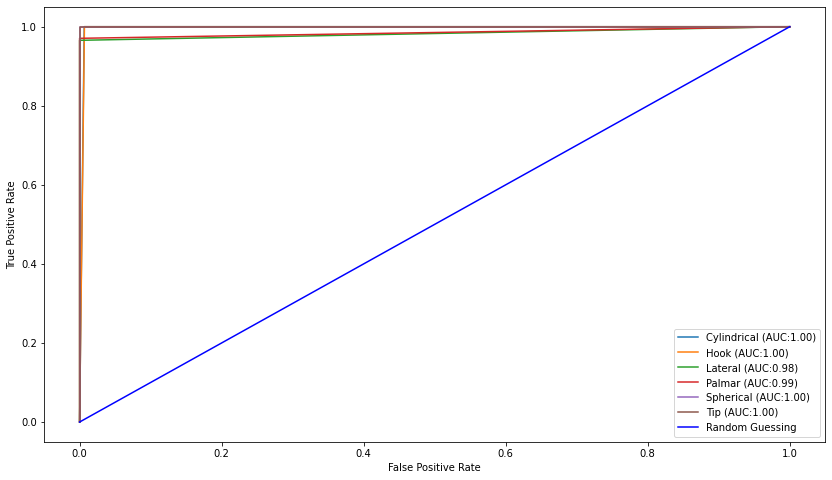

Variance PCA: 0.5080693960189819


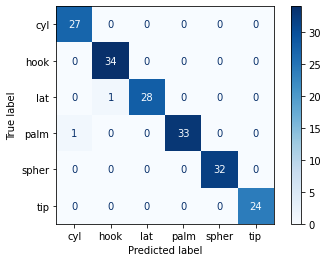

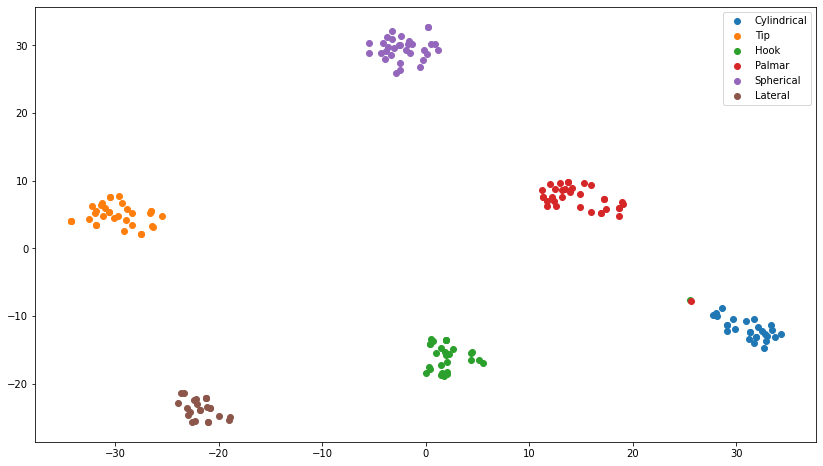

-----In Fold  0  -------- Of Process  0 ---------
test acc Fold  0 :  0.9888888597488403
********************************************************************
********************************************************************
********************************************************************
Evaluate on test data
1/1 [==============================] - 0s 490ms/step - loss: 0.0600 - accuracy: 0.9944
test loss, test acc: [0.05995471775531769, 0.9944444298744202]
ROC AUC score: 0.9963348765432097


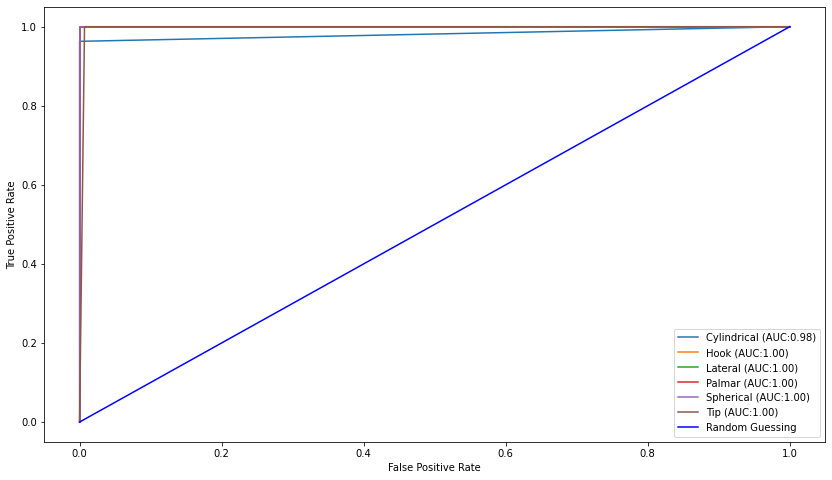

Variance PCA: 0.4457165002822876


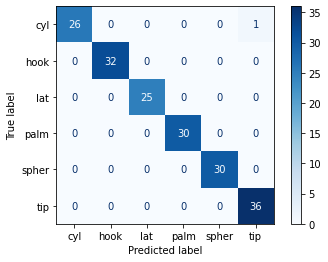

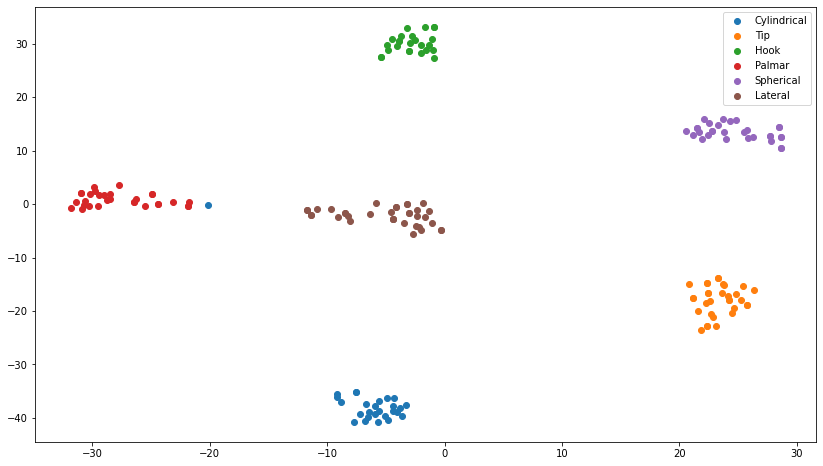

-----In Fold  1  -------- Of Process  0 ---------
test acc Fold  1 :  0.9944444298744202
********************************************************************
********************************************************************
********************************************************************
Evaluate on test data
1/1 [==============================] - 0s 493ms/step - loss: 0.0623 - accuracy: 0.9889
test loss, test acc: [0.06234162673354149, 0.9888888597488403]


ROC AUC score: 0.9927893518518519


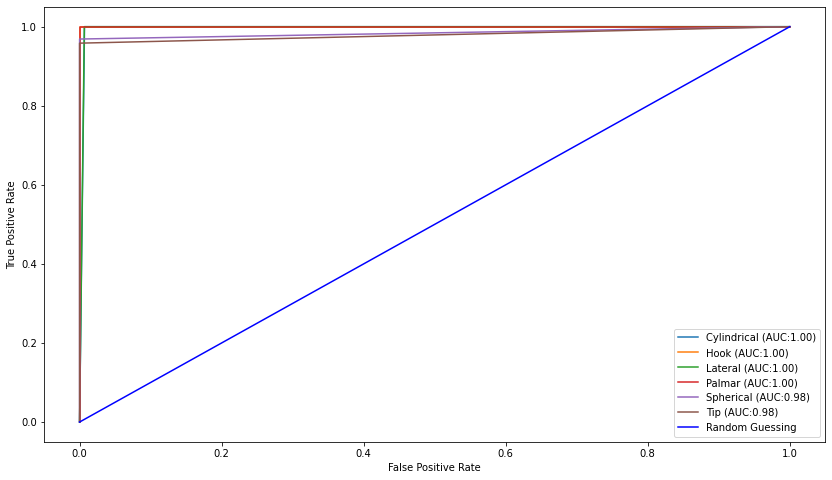

Variance PCA: 0.5027104020118713


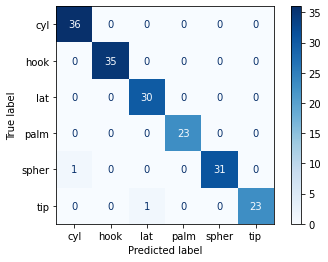

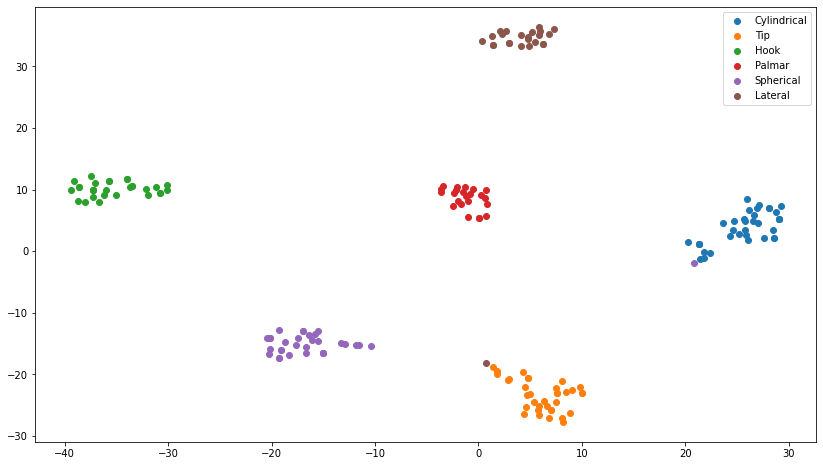

-----In Fold  2  -------- Of Process  0 ---------
test acc Fold  2 :  0.9888888597488403
********************************************************************
********************************************************************
********************************************************************
Evaluate on test data
1/1 [==============================] - 0s 488ms/step - loss: 0.0637 - accuracy: 0.9944
test loss, test acc: [0.06366586685180664, 0.9944444298744202]
ROC AUC score: 0.9960798122065729


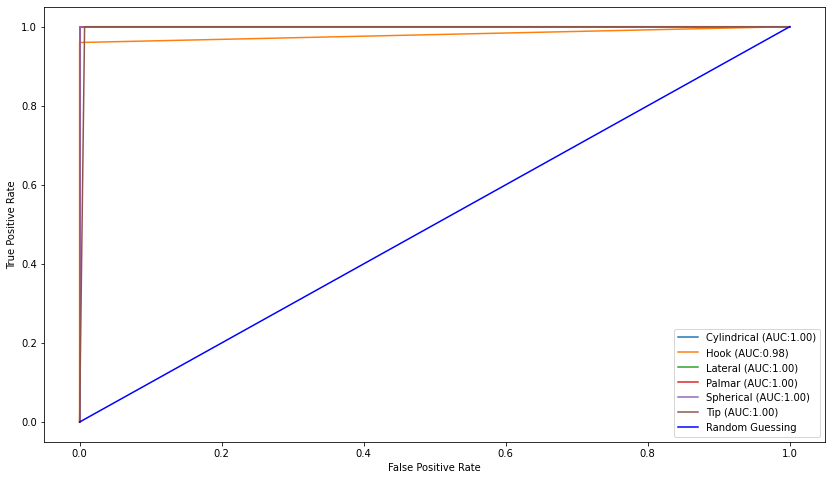

Variance PCA: 0.5093202590942383


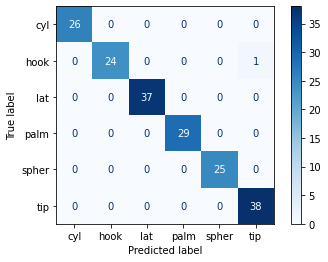

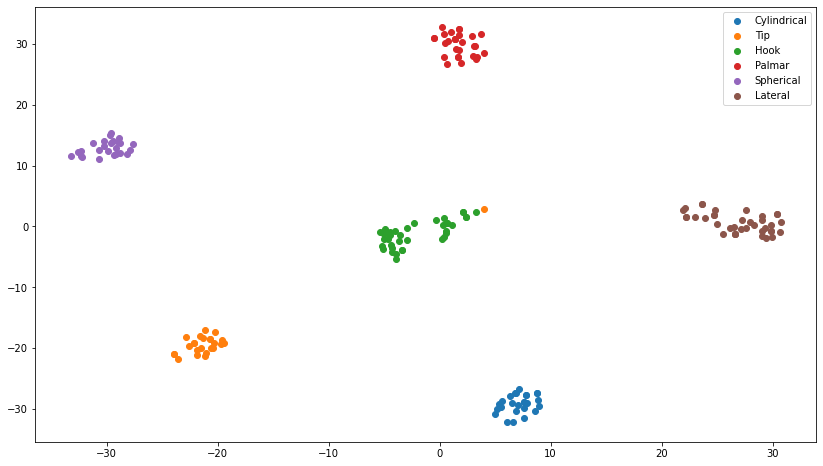

-----In Fold  3  -------- Of Process  0 ---------
test acc Fold  3 :  0.9944444298744202
********************************************************************
********************************************************************
********************************************************************
Evaluate on test data
1/1 [==============================] - 0s 488ms/step - loss: 0.0318 - accuracy: 1.0000
test loss, test acc: [0.03179605305194855, 1.0]
ROC AUC score: 1.0


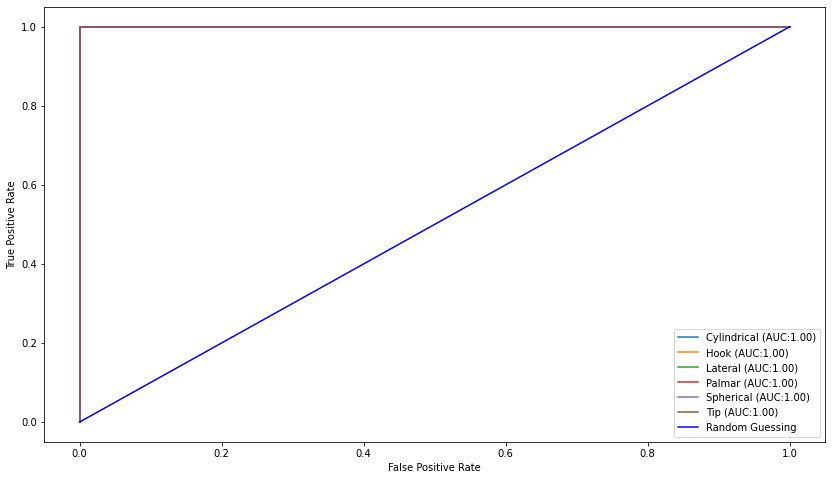

Variance PCA: 0.45955634117126465


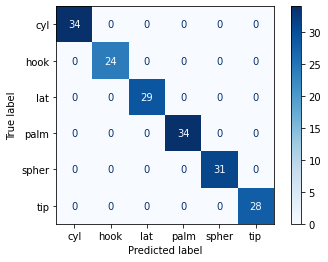

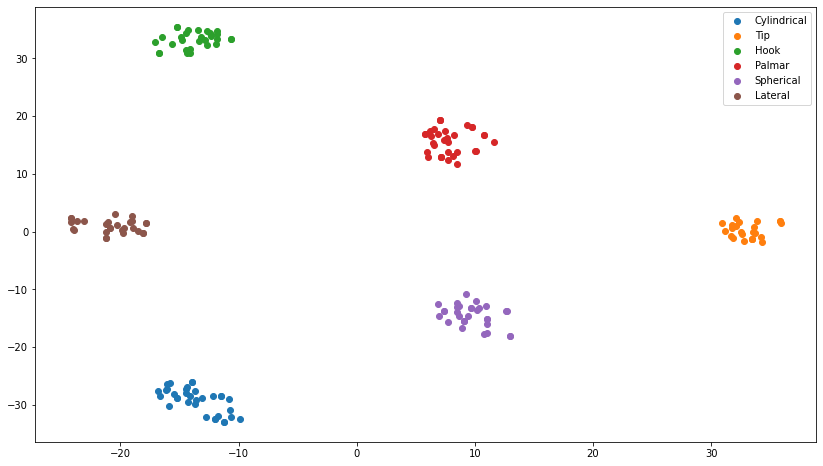

-----In Fold  4  -------- Of Process  0 ---------
test acc Fold  4 :  1.0
********************************************************************
********************************************************************
********************************************************************


In [33]:
for train, test in kfold.split(inputsALL, outputsALL):
  #print(inputsALL[train].shape)
  #print(outputsALL.iloc[train].shape)
  #print(undumm(np.array(outputsALL.iloc[test])))
  for x in range(reppeated_val):
      #load model
      del model
      model = My_Model(time_steps, features, n_batch, n_regularizer_k, n_regularizer_r, n_dropout, n_depth)
      # Fit model
      i=0
      while i < (n_epochs):
        #print("Model's epoch: ", i)
        history = model.fit(inputsALL[train], outputsALL.iloc[train],
                            validation_data=(inputsALL[test], outputsALL.iloc[test]),
                            validation_steps=1,
                            batch_size=n_batch, 
                            epochs=1,
                            verbose=0, 
                            shuffle=False
                            )     
        #print(history.history)   
        acc_local[i][Fold] = history.history['accuracy'][0]
        loss_local[i][Fold] = history.history['loss'][0]
        acc_local_t[i][Fold] = history.history['val_accuracy'][0]
        loss_local_T[i][Fold] = history.history['val_loss'][0]
        model.reset_states()
        i=i+1
      # Eval Model
      print("Evaluate on test data")
      results = model.evaluate(inputsALL[test], outputsALL.iloc[test], batch_size=n_batch, verbose=1)
      total_acc0 = total_acc0 + results[1]
      print("test loss, test acc:", results)
      #Save values          ###############################################
      y_pred = model.predict(inputsALL[test], batch_size=n_batch, verbose=0)
      pred_ones = y_pred.argmax(axis=-1)
      val_ones = np.array(outputsALL.iloc[test]).argmax(axis=-1)
      target= ['Cylindrical', 'Hook', 'Lateral', 'Palmar', 'Spherical', 'Tip']
      ## set plot figure size
      fig, c_ax = plt.subplots(1,1, figsize = (14, 8))
      print('ROC AUC score:', multiclass_roc_auc_score(val_ones, pred_ones))
      plt.show()
      plot_cm(val_ones, pred_ones)  
      ## TSNE + PCA
      truncated_model = create_truncated_model(model)
      hidden_features = truncated_model.predict(inputsALL[test], batch_size=n_batch, verbose=0)
      pca_result = pca.fit_transform(hidden_features)
      print('Variance PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))
      #tsne_results = tsne.fit_transform(pca_result)
      tsne_results = tsne.fit_transform(hidden_features)
      graph_tsne(outputsALL.iloc[test], tsne_results)
      plt.show()
      
      print("-----In Fold ", Fold, " -------- Of Process ", x, "---------")

  total_acc0 = (total_acc0)/reppeated_val                            ##
  print("test acc Fold ", Fold, ": ", total_acc0)
  Fold=Fold+1
  total_acc0 = 0;
  print("********************************************************************")
  print("********************************************************************")
  print("********************************************************************")

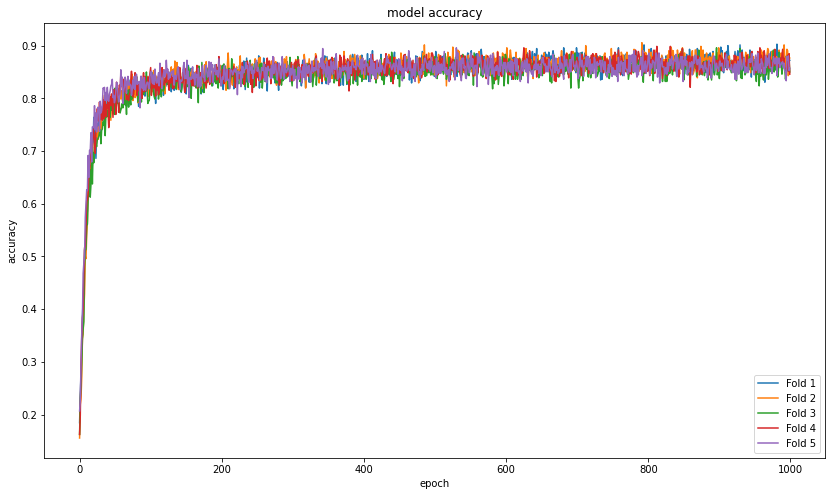

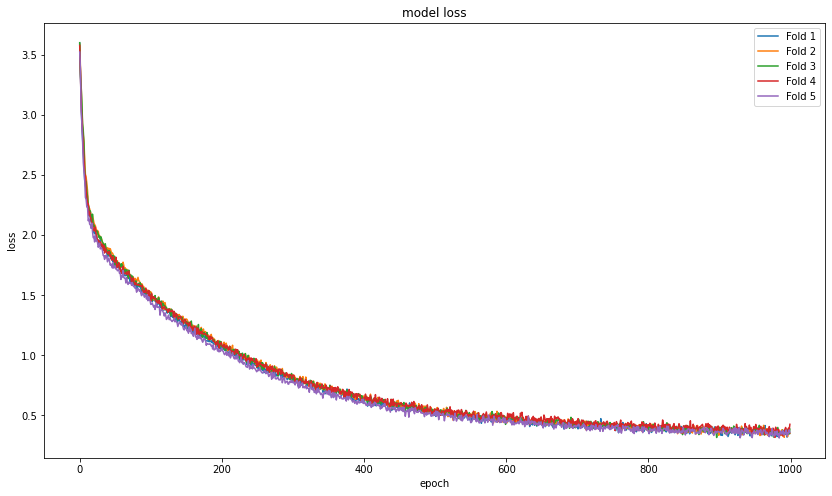

In [34]:
fig1, c_ax1 = plt.subplots(1,1, figsize = (14, 8))
plot_acc(acc_local)
fig2, c_ax2 = plt.subplots(1,1, figsize = (14, 8))
plot_loss(loss_local)

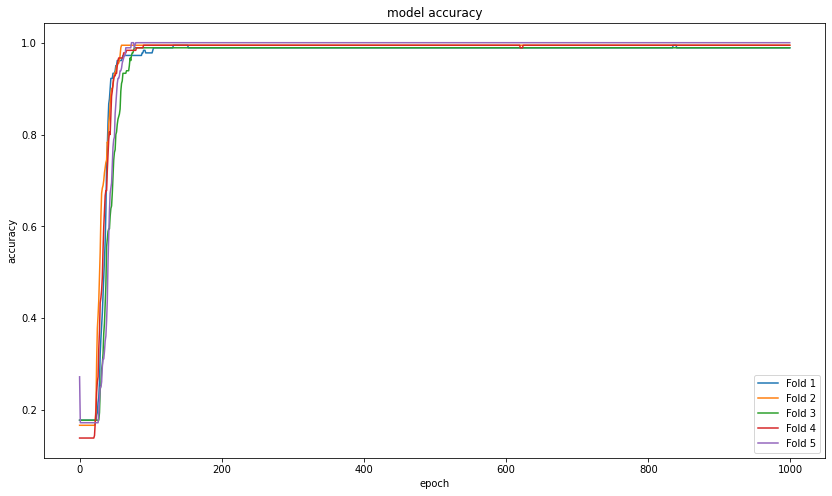

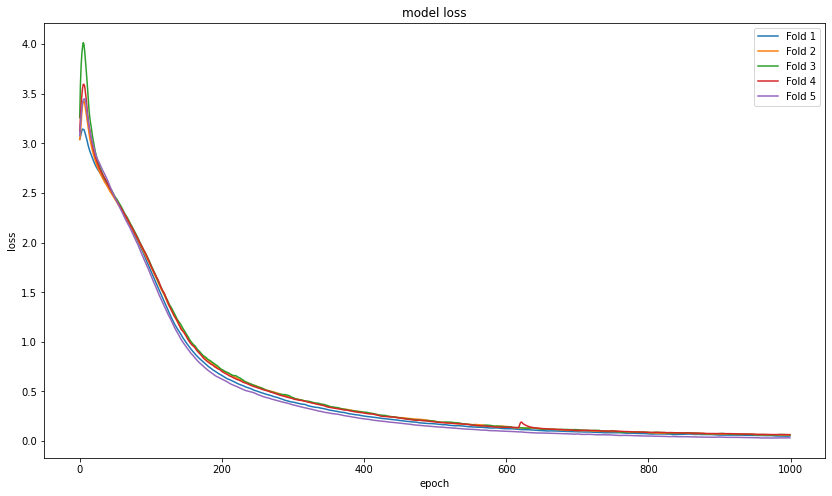

In [35]:
fig1, c_ax1 = plt.subplots(1,1, figsize = (14, 8))
plot_acc(acc_local_t)
fig2, c_ax2 = plt.subplots(1,1, figsize = (14, 8))
plot_loss(loss_local_T)

In [36]:
Done = 69
Done

69

#### Machine Learning Algorithms

##### Wavelet plot

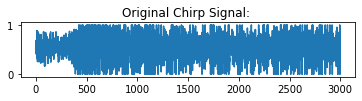

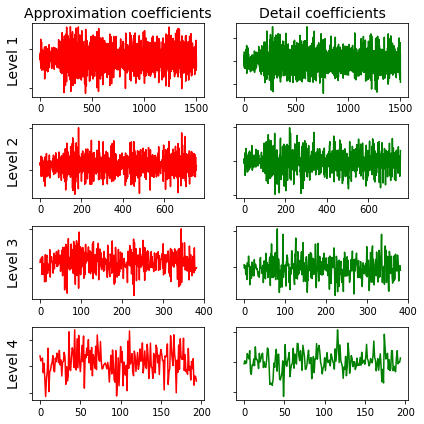

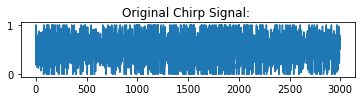

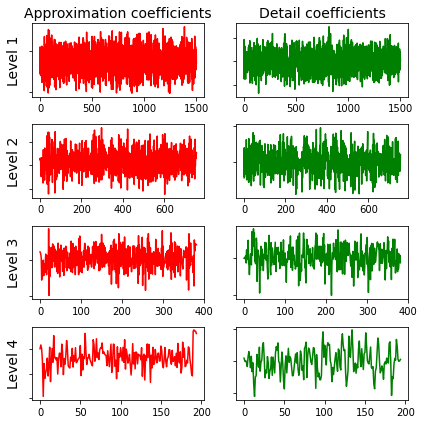

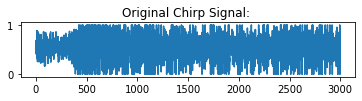

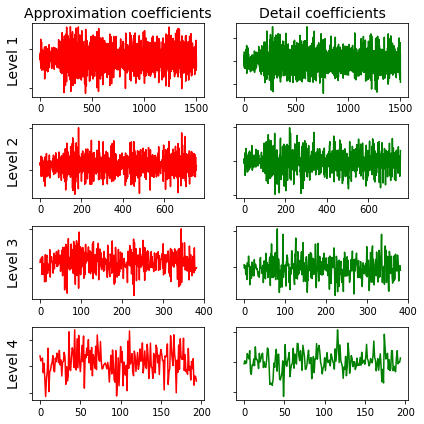

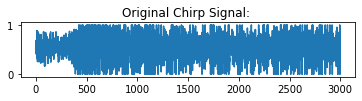

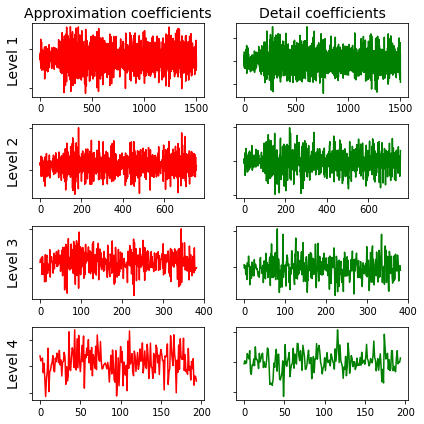

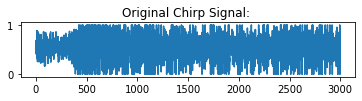

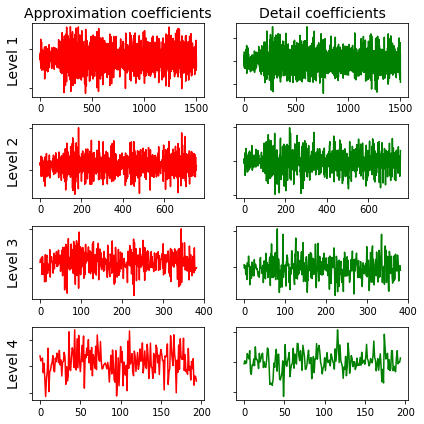

In [ ]:
for train, test in kfold.split(inputsALL, outputsALL):
  data = inputsALL[train]
  data1 = np.zeros((data.shape[0], data.shape[1]));
  coeff_d = np.zeros((data.shape[0], data.shape[1]));
  for i in range(data.shape[0]):
    for j in range(data.shape[1]):
      data1[i][j] = data[i][j][0]
  data_out = outputsALL.iloc[train]
  datax=data1[0]
  fig, ax = plt.subplots(figsize=(6,1))
  ax.set_title("Original Chirp Signal: ")
  ax.plot(datax)
  plt.show()
  waveletname = 'sym5'
  fig, axarr = plt.subplots(nrows=4, ncols=2, figsize=(6,6))
  for ii in range(4):
    (datax, coeff_d) = pywt.dwt(datax, waveletname)
    axarr[ii, 0].plot(datax, 'r')
    axarr[ii, 1].plot(coeff_d, 'g')
    axarr[ii, 0].set_ylabel("Level {}".format(ii + 1), fontsize=14, rotation=90)
    axarr[ii, 0].set_yticklabels([])
    if ii == 0:
        axarr[ii, 0].set_title("Approximation coefficients", fontsize=14)
        axarr[ii, 1].set_title("Detail coefficients", fontsize=14)
    axarr[ii, 1].set_yticklabels([])
  plt.tight_layout()
  plt.show()

##### Functions

In [ ]:
def get_channels(d_shape1, s_shape2, data):
  #Get channel 1
  data1 = np.zeros((d_shape1, s_shape2));
  for i in range(d_shape1):
    for j in range(s_shape2):
      data1[i][j] = data[i][j][0]
  #Get channel 2
  data2 = np.zeros((d_shape1, s_shape2));
  for i in range(d_shape1):
    for j in range(s_shape2):
      data2[i][j] = data[i][j][1]
  return data1, data2

In [ ]:
def get_wavelets(d_shape1, data1, data2):
  ch1w = np.zeros((data.shape[0], 8, 1600));
  ch2w = np.zeros((data.shape[0], 8, 1600));
  for i in range(data1.shape[0]):
    #ch1
    datax=data1[i]
    n = 0;
    for ii in range(4):
      (datax, coeff_d) = pywt.dwt(datax, waveletname)
      #print("Ch1", len(datax))
      for j in range(len(datax)):
        ch1w[i][n][j] = datax[j]
        ch1w[i][n+1][j] = coeff_d[j]
      n=n+2
    #ch2
    datax=data2[i]
    m = 0;
    for ii in range(4):
      (datax, coeff_d) = pywt.dwt(datax, waveletname)
      #print("Ch2", len(datax))
      for j in range(len(datax)):
        ch2w[i][m][j] = datax[j]
        ch2w[i][m+1][j] = coeff_d[j]
      m=m+2
  return ch1w, ch2w

In [ ]:
def get_features(f_shape, ch1w, ch2w):
  f1 = np.zeros((f_shape, 16));
  f2 = np.zeros((f_shape, 16));
  f3 = np.zeros((f_shape, 16));
  f4 = np.zeros((f_shape, 16));
  f5 = np.zeros((f_shape, 16));
  f6 = np.zeros((f_shape, 16));
  f7 = np.zeros((f_shape, 16));
  f8 = np.zeros((f_shape, 16));
  f9 = np.zeros((f_shape, 16));
  f10 = np.zeros((f_shape, 16));
  f11 = np.zeros((f_shape, 16));
  f12 = np.zeros((f_shape, 16)); 
  for i in range(f1.shape[0]):
    n = 0
    for j in range(8):
      f1[i][n] = pysiology.electromyography.getAAC(ch1w[i][j])
      f1[i][n+8] = pysiology.electromyography.getAAC(ch2w[i][j])
      n = n + 1
    n = 0
    for j in range(8):
      f2[i][n] = pysiology.electromyography.getDASDV(ch1w[i][j])
      f2[i][n+8] = pysiology.electromyography.getDASDV(ch2w[i][j])
      n = n + 1
    n = 0
    for j in range(8):
      f3[i][n] = pysiology.electromyography.getLOG(ch1w[i][j])
      f4[i][n+8] = pysiology.electromyography.getLOG(ch2w[i][j])
      n = n + 1
    n = 0
    for j in range(8):
      f4[i][n] = pysiology.electromyography.getMAV(ch1w[i][j])
      f4[i][n+8] = pysiology.electromyography.getMAV(ch2w[i][j])
      n = n + 1
    n = 0
    for j in range(8):
      f5[i][n] = pysiology.electromyography.getMYOP(ch1w[i][j],threshold=0.05)
      f5[i][n+8] = pysiology.electromyography.getMYOP(ch2w[i][j],threshold=0.05)
      n = n + 1
    n = 0
    for j in range(8):
      f6[i][n] = pysiology.electromyography.getRMS(ch1w[i][j])
      f6[i][n+8] = pysiology.electromyography.getRMS(ch2w[i][j])
      n = n + 1
    n = 0
    for j in range(8):
      f7[i][n] = pysiology.electromyography.getSSC(ch1w[i][j], threshold=0.05)
      f7[i][n+8] = pysiology.electromyography.getSSC(ch2w[i][j],threshold=0.05)
      n = n + 1
    n = 0
    for j in range(8):
      f8[i][n] = pysiology.electromyography.getSSI(ch1w[i][j])
      f8[i][n+8] = pysiology.electromyography.getSSI(ch2w[i][j])
      n = n + 1
    n = 0
    for j in range(8):
      f9[i][n] = pysiology.electromyography.getVAR(ch1w[i][j])
      f9[i][n+8] = pysiology.electromyography.getVAR(ch2w[i][j])
      n = n + 1
    n = 0
    for j in range(8):
      f10[i][n] = pysiology.electromyography.getWAMP(ch1w[i][j],threshold=0.05)
      f10[i][n+8] = pysiology.electromyography.getWAMP(ch2w[i][j],threshold=0.05)
      n = n + 1
    n = 0
    for j in range(8):
      f11[i][n] = pysiology.electromyography.getWL(ch1w[i][j])
      f11[i][n+8] = pysiology.electromyography.getWL(ch2w[i][j])
      n = n + 1
    n = 0
    for j in range(8):
      f12[i][n] = pysiology.electromyography.getZC(ch1w[i][j],threshold=0.05)
      f12[i][n+8] = pysiology.electromyography.getZC(ch2w[i][j],threshold=0.05)
      n = n + 1
  return f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11, f12

In [ ]:
def classic_training(features, grasps, featurest, graspst):
  clf =MultiOutputClassifier(LDA(solver='lsqr')).fit(features,grasps)
  T1 = clf.score(featurest,graspst)
  #print('LDA')
  clf =MultiOutputClassifier(DTC()).fit(features,grasps)
  T2 = clf.score(featurest,graspst)
  #print('DTC')
  clf =MultiOutputClassifier(RFC()).fit(features,grasps)
  T3 = clf.score(featurest,graspst)
  #print('RFC')
  clf =MultiOutputClassifier(SVM(kernel='poly', degree=8)).fit(features,grasps)
  T4 = clf.score(featurest,graspst)
  #print('SVM')
  clf =MultiOutputClassifier(KNN()).fit(features,grasps)
  T5 = clf.score(featurest,graspst)
  #print('KNN')
  clf =MultiOutputClassifier(NB()).fit(features,grasps)
  T6 = clf.score(featurest,graspst)
  #print('NB')
  
  return T1, T2, T3, T4, T5, T6

##### Wavelet COmponents

In [ ]:
waveletname = pywt.wavelist('bior')[8]
print(waveletname)

bior3.3


In [ ]:
for train, test in kfold.split(inputsALL, outputsALL):
  data = inputsALL[train]
  data_out = outputsALL.iloc[train] 
  datat = inputsALL[test]
  data_outt = outputsALL.iloc[test]
  ##Get channels
  data1, data2 = get_channels(data.shape[0], data.shape[1], data)
  data1t, data2t = get_channels(datat.shape[0], datat.shape[1], datat)
  ##Get wavelets per samples
  ch1w, ch2w = get_wavelets(data1.shape[0], data1, data2)
  ch1wt, ch2wt = get_wavelets(data1t.shape[0], data1t, data2t)
  ##Print shape wavelet vectors
  #print("Wavelet CH1: ", ch1w.shape)
  #print("Wavelet CH2: ", ch2w.shape)
  ##Traditional features Extraction
  f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11, f12 = get_features(data.shape[0], ch1w, ch2w)
  f1t, f2t, f3t, f4t, f5t, f6t, f7t, f8t, f9t, f10t, f11t, f12t = get_features(datat.shape[0], ch1wt, ch2wt)
  ##Train models per feature
  print('Singled...')
  print('',
        classic_training(f1, data_out, f1t, data_outt),
        '\n',
        classic_training(f2, data_out, f2t, data_outt),
        '\n',
        classic_training(f3, data_out, f3t, data_outt),
        '\n',
        classic_training(f4, data_out, f4t, data_outt),
        '\n',
        classic_training(f5, data_out, f5t, data_outt),
        '\n',
        classic_training(f6, data_out, f6t, data_outt),
        '\n',
        classic_training(f7, data_out, f7t, data_outt),
        '\n',
        classic_training(f8, data_out, f8t, data_outt),
        '\n',
        classic_training(f9, data_out, f9t, data_outt),
        '\n',
        classic_training(f10, data_out, f10t, data_outt),
        '\n',
        classic_training(f11, data_out, f11t, data_outt),
        '\n',
        classic_training(f12, data_out, f12t, data_outt))
  ##Train model with combines features
  print('Combined...')
  f_0=np.concatenate((f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12),axis=1)
  ft_0=np.concatenate((f1t,f2t,f3t,f4t,f5t,f6t,f7t,f8t,f9t,f10t,f11t,f12t),axis=1)
  f_1=np.concatenate((f3,f4,f6,f9,f10,f11,f12),axis=1)
  ft_1=np.concatenate((f3t,f4t,f6t,f9t,f10t,f11t,f12t),axis=1)
  f_2=np.concatenate((f6,f11,f12),axis=1)
  ft_2=np.concatenate((f6t,f11t,f12t),axis=1)
  f_3=np.concatenate((f2,f3,f5,f6,f9,f10,f11,f12),axis=1)
  ft_3=np.concatenate((f2t,f3t,f5t,f6t,f9t,f10t,f11t,f12t),axis=1)
  f_4=np.concatenate((f5,f8,f10),axis=1)
  ft_4=np.concatenate((f5t,f8t,f10t),axis=1)
  f_5=np.concatenate((f4,f7,f11,f12),axis=1)
  ft_5=np.concatenate((f4t,f7t,f11t,f12t),axis=1)
  f_6=np.concatenate((f4,f5,f10,f11),axis=1)
  ft_6=np.concatenate((f4t,f5t,f10t,f11t),axis=1)
  f_7=np.concatenate((f1,f2,f3,f6),axis=1)
  ft_7=np.concatenate((f1t,f2t,f3t,f6t),axis=1)
  f_8=np.concatenate((f4,f11),axis=1)
  ft_8=np.concatenate((f4t,f11t),axis=1)
  f_9=np.concatenate((f1,f3,f5,f10),axis=1)
  ft_9=np.concatenate((f1t,f3t,f5t,f10t),axis=1)
  f_10=np.concatenate((f5,f10),axis=1)
  ft_10=np.concatenate((f5t,f10t),axis=1)
  print('',
        classic_training(f_0, data_out, ft_0, data_outt),
        '\n',
        classic_training(f_1, data_out, ft_1, data_outt),
        '\n',
        classic_training(f_2, data_out, ft_2, data_outt),
        '\n',
        classic_training(f_3, data_out, ft_3, data_outt),
        '\n',
        classic_training(f_4, data_out, ft_4, data_outt),
        '\n',
        classic_training(f_5, data_out, ft_5, data_outt),
        '\n',
        classic_training(f_6, data_out, ft_6, data_outt),
        '\n',
        classic_training(f_7, data_out, ft_7, data_outt),
        '\n',
        classic_training(f_8, data_out, ft_8, data_outt),
        '\n',
        classic_training(f_9, data_out, ft_9, data_outt),
        '\n',
        classic_training(f_10, data_out, ft_10, data_outt))


Singled...
 (0.37777777777777777, 0.8444444444444444, 0.8833333333333333, 0.7833333333333333, 0.7611111111111111, 0.2833333333333333) 
 (0.3611111111111111, 0.8222222222222222, 0.8666666666666667, 0.5055555555555555, 0.7333333333333333, 0.22777777777777777) 
 (0.17222222222222222, 0.8777777777777778, 0.9, 0.03888888888888889, 0.9, 0.3388888888888889) 
 (0.4777777777777778, 0.9166666666666666, 0.9777777777777777, 0.8666666666666667, 0.9888888888888889, 0.39444444444444443) 
 (0.2611111111111111, 0.8, 0.8222222222222222, 0.35555555555555557, 0.6611111111111111, 0.2) 
 (0.5, 0.9388888888888889, 0.9777777777777777, 0.9444444444444444, 0.9888888888888889, 0.42777777777777776) 
 (0.2722222222222222, 0.7888888888888889, 0.8166666666666667, 0.45, 0.7333333333333333, 0.2777777777777778) 
 (0.45, 0.9388888888888889, 0.9777777777777777, 0.7888888888888889, 0.9611111111111111, 0.4222222222222222) 
 (0.45, 0.9444444444444444, 0.9777777777777777, 0.7888888888888889, 0.9611111111111111, 0.42222222222

In [ ]:
ch1w[0][1].shape

(1600,)

In [ ]:
f1.shape

(720, 16)

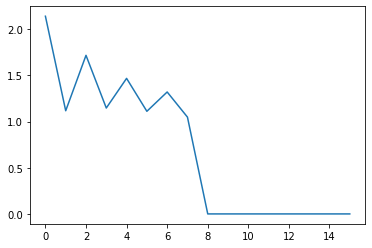

In [ ]:
plt.plot(f3[12])

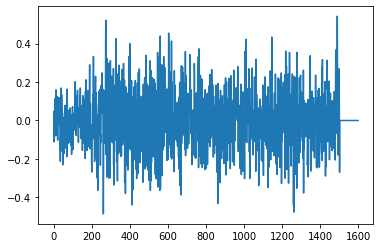

In [ ]:
plt.plot(ch1w[0][1])

In [ ]:
clf = MultiOutputClassifier(SVM(kernel='poly', degree=8)).fit(f1, data_out)
clf.score(f1t, data_outt)

0.6611111111111111

## **Crossvals**

In [ ]:
total_acc0 = 0
total_acc1 = 0
total_acc2 = 0
total_acc3 = 0
total_acc4 = 0
total_accS1 = 0
all_30_outputs = np.zeros((10, 180))  ##
sbj = 0     #delimitator

### Input 4/1/0

In [ ]:
inputsTF = np.empty((720, 3000, 2))
k=0
m=0
for i in range(120):
  for j in range(3000):
    inputsTF[k,j,0]=cyl_ch1[i+m+sbj,j]
    inputsTF[k,j,1]=cyl_ch2[i+m+sbj,j]
    inputsTF[k+1,j,0]=hook_ch1[i+m+sbj,j]
    inputsTF[k+1,j,1]=hook_ch2[i+m+sbj,j]
    inputsTF[k+2,j,0]=lat_ch1[i+m+sbj,j]
    inputsTF[k+2,j,1]=lat_ch2[i+m+sbj,j]
    inputsTF[k+3,j,0]=palm_ch1[i+m+sbj,j]
    inputsTF[k+3,j,1]=palm_ch2[i+m+sbj,j]
    inputsTF[k+4,j,0]=spher_ch1[i+m+sbj,j]
    inputsTF[k+4,j,1]=spher_ch2[i+m+sbj,j]
    inputsTF[k+5,j,0]=tip_ch1[i+m+sbj,j]
    inputsTF[k+5,j,1]=tip_ch2[i+m+sbj,j]
  k=k+6;
inputsTF.shape

(720, 3000, 2)

In [ ]:
inputsPF = np.empty((180, 3000, 2))
k=0
m=120
for i in range(30):
  for j in range(3000):
    inputsPF[k,j,0]=cyl_ch1[i+m+sbj,j]
    inputsPF[k,j,1]=cyl_ch2[i+m+sbj,j]
    inputsPF[k+1,j,0]=hook_ch1[i+m+sbj,j]
    inputsPF[k+1,j,1]=hook_ch2[i+m+sbj,j]
    inputsPF[k+2,j,0]=lat_ch1[i+m+sbj,j]
    inputsPF[k+2,j,1]=lat_ch2[i+m+sbj,j]
    inputsPF[k+3,j,0]=palm_ch1[i+m+sbj,j]
    inputsPF[k+3,j,1]=palm_ch2[i+m+sbj,j]
    inputsPF[k+4,j,0]=spher_ch1[i+m+sbj,j]
    inputsPF[k+4,j,1]=spher_ch2[i+m+sbj,j]
    inputsPF[k+5,j,0]=tip_ch1[i+m+sbj,j]
    inputsPF[k+5,j,1]=tip_ch2[i+m+sbj,j]
  k=k+6;
inputsPF.shape

(180, 3000, 2)

In [ ]:
x_train, x_test = inputsTF, inputsPF
np.array(x_train).shape, np.array(x_test).shape

((720, 3000, 2), (180, 3000, 2))

#### Build Model

In [ ]:
time_steps = np.array(x_train).shape[1]
features = np.array(x_train).shape[2]
n_batch = 180
n_regularizer_k = 0.001
n_regularizer_r = 0.001
n_optimizer = SGD(learning_rate=0.2)#Adam(learning_rate=0.0001)
n_dropout = 0.9

n_regularizer_k, n_regularizer_r, n_epochs, n_optimizer, n_depth
model = My_Model(time_steps, features, n_batch, n_regularizer_k, n_regularizer_r, n_dropout, n_depth)  #just first time
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(180, 3000, 2)]     0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (180, 3000, 150)     46800       ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (180, 3000, 150)     0           ['bidirectional[0][0]']          
                                                                                                  
 batch_normalization (BatchNorm  (180, 3000, 150)    600         ['dropout[0][0]']                
 alization)                                                                                   

In [ ]:
for x in range(10):             ###
  #load model
  del model
  model = My_Model(time_steps, features, n_batch, n_regularizer_k, n_regularizer_r, n_dropout, n_depth)
  # Fit model
  i=0
  while i < (n_epochs):
    print("Model's epoch: ", i)
    his = model.fit(
        x=x_train,
        y=y_train,
        batch_size=n_batch, 
        epochs=1,
        verbose=1, 
        shuffle=False
        )
    #print(his.history['accuracy'])
    model.reset_states()
    i=i+1
  # Eval Model
  print("Evaluate on test data")
  results = model.evaluate(x_test, y_test, batch_size=n_batch, verbose=1)
  total_acc0 = total_acc0 + results[1]
  print("test loss, test acc:", results)
  #Save values          ###############################################
  y_pred = model.predict(x_test, batch_size=n_batch, verbose=1)
  test_ones = np.argmax(y_pred, axis=1)
  all_30_outputs[x,:] = test_ones
for x in range(10):
  print(all_30_outputs[x,:])

Model's epoch:  0
4/4 [==============================] - 14s 602ms/step - loss: 3.0215 - accuracy: 0.1875
Model's epoch:  1
4/4 [==============================] - 2s 606ms/step - loss: 2.9657 - accuracy: 0.1931
Model's epoch:  2
4/4 [==============================] - 2s 608ms/step - loss: 2.9646 - accuracy: 0.1681
Model's epoch:  3
4/4 [==============================] - 2s 607ms/step - loss: 2.8476 - accuracy: 0.1986
Model's epoch:  4
4/4 [==============================] - 2s 610ms/step - loss: 2.8852 - accuracy: 0.1986
Model's epoch:  5
4/4 [==============================] - 2s 607ms/step - loss: 2.7649 - accuracy: 0.2250
Model's epoch:  6
4/4 [==============================] - 2s 608ms/step - loss: 2.8036 - accuracy: 0.2111
Model's epoch:  7
4/4 [==============================] - 2s 621ms/step - loss: 2.7039 - accuracy: 0.2569
Model's epoch:  8
4/4 [==============================] - 2s 611ms/step - loss: 2.6941 - accuracy: 0.2444
Model's epoch:  9
4/4 [==============================]

1/1 [==============================] - 2s 2s/step - loss: 1.6897 - accuracy: 1.0000
test loss, test acc: [1.689705729484558, 1.0]


1/1 [==============================] - 1s 1s/step
Model's epoch:  0
4/4 [==============================] - 8s 626ms/step - loss: 2.9744 - accuracy: 0.1903
Model's epoch:  1
4/4 [==============================] - 2s 626ms/step - loss: 2.9656 - accuracy: 0.1722
Model's epoch:  2
4/4 [==============================] - 3s 629ms/step - loss: 2.8618 - accuracy: 0.1958
Model's epoch:  3
4/4 [==============================] - 3s 626ms/step - loss: 2.9401 - accuracy: 0.1806
Model's epoch:  4
4/4 [==============================] - 3s 628ms/step - loss: 2.7771 - accuracy: 0.1903
Model's epoch:  5
4/4 [==============================] - 3s 630ms/step - loss: 2.7805 - accuracy: 0.2000
Model's epoch:  6
4/4 [==============================] - 3s 635ms/step - loss: 2.7346 - accuracy: 0.1944
Model's epoch:  7
4/4 [==============================] - 3s 629ms/step - loss: 2.7223 - accuracy: 0.2167
Model's epoch:  8
4/4 [==============================] - 3s 629ms/step - loss: 2.6108 - accuracy: 0.2403
Model

1/1 [==============================] - 2s 2s/step - loss: 1.7636 - accuracy: 1.0000
test loss, test acc: [1.7635605335235596, 1.0]


1/1 [==============================] - 1s 1s/step
Model's epoch:  0
4/4 [==============================] - 8s 629ms/step - loss: 2.9502 - accuracy: 0.1722
Model's epoch:  1
4/4 [==============================] - 3s 625ms/step - loss: 3.0278 - accuracy: 0.1819
Model's epoch:  2
4/4 [==============================] - 3s 631ms/step - loss: 2.8523 - accuracy: 0.1917
Model's epoch:  3
4/4 [==============================] - 3s 626ms/step - loss: 2.9762 - accuracy: 0.1583
Model's epoch:  4
4/4 [==============================] - 3s 625ms/step - loss: 2.8025 - accuracy: 0.2069
Model's epoch:  5
4/4 [==============================] - 3s 626ms/step - loss: 2.7560 - accuracy: 0.2028
Model's epoch:  6
4/4 [==============================] - 2s 621ms/step - loss: 2.7173 - accuracy: 0.2236
Model's epoch:  7
4/4 [==============================] - 3s 637ms/step - loss: 2.6810 - accuracy: 0.2292
Model's epoch:  8
4/4 [==============================] - 3s 627ms/step - loss: 2.6158 - accuracy: 0.2514
Model

#### Results

In [ ]:
total_acc0 = (total_acc0)/10                            ##
print("test acc CV0: ", total_acc0)

test acc CV0:  0.997777771949768


1/1 [==============================] - 0s 251ms/step
[0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0
 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 2 2 3 4 5 0 1 2 3 4 5 0 1
 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2
 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3
 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5] 

[[30  0  0  0  0  0]
 [ 0 29  0  0  0  0]
 [ 0  1 30  0  0  0]
 [ 0  0  0 30  0  0]
 [ 0  0  0  0 30  0]
 [ 0  0  0  0  0 30]] 





(0.9946236559139785, 0.9944444444444445, 0.9944429008057795, None)

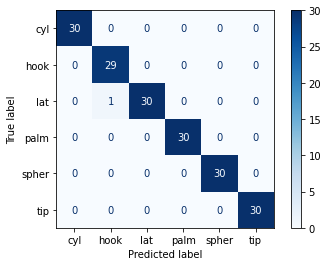

In [ ]:
w_test = []
for i in range(30):      #into subjects
  w_test.append('cyl')
  w_test.append('hook')
  w_test.append('lat')
  w_test.append('palm')
  w_test.append('spher')
  w_test.append('tip')

w_pred = []
y_pred = model.predict(x_test, batch_size=n_batch, verbose=1)
test_ones = np.argmax(y_pred, axis=1)
for x in range(180):
  if test_ones[x] == 0:
    w_pred.append('cyl')
  elif test_ones[x] == 1:
    w_pred.append('hook')
  elif test_ones[x] == 2:
    w_pred.append('lat')
  elif test_ones[x] == 3:
    w_pred.append('palm')
  elif test_ones[x] == 4:
    w_pred.append('spher')
  elif test_ones[x] == 5:
    w_pred.append('tip')

print(test_ones, '\n')

labels = ["cyl", "hook", "lat", "palm", "spher", "tip"]
cm = confusion_matrix(w_pred, w_test, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

print(cm, '\n')

print('\n')
precision_recall_fscore_support(w_test, w_pred, average='weighted')








****************************************************

In [ ]:
done0=1
done0

1

### Input 3/1/1 per Subjects

In [ ]:
inputsTF = np.empty((720, 3000, 2))
k=0
m=0
for i in range(120):
  if i == 90:
    m = 30
  for j in range(3000):
    inputsTF[k,j,0]=cyl_ch1[i+m+sbj,j]
    inputsTF[k,j,1]=cyl_ch2[i+m+sbj,j]
    inputsTF[k+1,j,0]=hook_ch1[i+m+sbj,j]
    inputsTF[k+1,j,1]=hook_ch2[i+m+sbj,j]
    inputsTF[k+2,j,0]=lat_ch1[i+m+sbj,j]
    inputsTF[k+2,j,1]=lat_ch2[i+m+sbj,j]
    inputsTF[k+3,j,0]=palm_ch1[i+m+sbj,j]
    inputsTF[k+3,j,1]=palm_ch2[i+m+sbj,j]
    inputsTF[k+4,j,0]=spher_ch1[i+m+sbj,j]
    inputsTF[k+4,j,1]=spher_ch2[i+m+sbj,j]
    inputsTF[k+5,j,0]=tip_ch1[i+m+sbj,j]
    inputsTF[k+5,j,1]=tip_ch2[i+m+sbj,j]
  k=k+6;
inputsTF.shape

(720, 3000, 2)

In [ ]:
inputsPF = np.empty((180, 3000, 2))
k=0
m=90
for i in range(30):
  for j in range(3000):
    inputsPF[k,j,0]=cyl_ch1[i+m+sbj,j]
    inputsPF[k,j,1]=cyl_ch2[i+m+sbj,j]
    inputsPF[k+1,j,0]=hook_ch1[i+m+sbj,j]
    inputsPF[k+1,j,1]=hook_ch2[i+m+sbj,j]
    inputsPF[k+2,j,0]=lat_ch1[i+m+sbj,j]
    inputsPF[k+2,j,1]=lat_ch2[i+m+sbj,j]
    inputsPF[k+3,j,0]=palm_ch1[i+m+sbj,j]
    inputsPF[k+3,j,1]=palm_ch2[i+m+sbj,j]
    inputsPF[k+4,j,0]=spher_ch1[i+m+sbj,j]
    inputsPF[k+4,j,1]=spher_ch2[i+m+sbj,j]
    inputsPF[k+5,j,0]=tip_ch1[i+m+sbj,j]
    inputsPF[k+5,j,1]=tip_ch2[i+m+sbj,j]
  k=k+6;
inputsPF.shape

(180, 3000, 2)

In [ ]:
x_train, x_test = inputsTF, inputsPF
np.array(x_train).shape, np.array(x_test).shape

((720, 3000, 2), (180, 3000, 2))

In [ ]:
all_30_outputs = np.zeros((10, 180))  ##

#### Build Model

In [ ]:
time_steps = np.array(x_train).shape[1]
features = np.array(x_train).shape[2]
n_batch = 180
n_regularizer_k = 0.001
n_regularizer_r = 0.001
n_optimizer = SGD(learning_rate=0.2)
n_dropout = 0.9

n_regularizer_k, n_regularizer_r, n_epochs, n_optimizer, n_depth
model = My_Model(time_steps, features, n_batch, n_regularizer_k, n_regularizer_r, n_dropout, n_depth)  #just first time
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(180, 3000, 2)]     0           []                               
                                                                                                  
 bidirectional_22 (Bidirectiona  (180, 3000, 150)    46800       ['input_12[0][0]']               
 l)                                                                                               
                                                                                                  
 dropout_33 (Dropout)           (180, 3000, 150)     0           ['bidirectional_22[0][0]']       
                                                                                                  
 batch_normalization_33 (BatchN  (180, 3000, 150)    600         ['dropout_33[0][0]']      

In [ ]:
for x in range(10):
  #load model
  del model
  model = My_Model(time_steps, features, n_batch, n_regularizer_k, n_regularizer_r, n_dropout, n_depth)
  # Fit model
  i=0
  while i < (n_epochs):
    print("Model's epoch: ", i)
    model.fit(
        x=x_train,
        y=y_train,
        batch_size=n_batch, 
        epochs=1,
        verbose=1, 
        shuffle=False
        )
    model.reset_states()
    i=i+1
  # Eval Model
  print("Evaluate on test data")
  results = model.evaluate(x_test, y_test, batch_size=n_batch, verbose=1)
  total_acc1 = total_acc1 + results[1]
  print("test loss, test acc:", results)
  #Save values          ###############################################
  y_pred = model.predict(x_test, batch_size=n_batch, verbose=1)
  test_ones = np.argmax(y_pred, axis=1)
  all_30_outputs[x,:] = test_ones
for x in range(10):
  print(all_30_outputs[x,:])

Model's epoch:  0
4/4 [==============================] - 8s 629ms/step - loss: 3.0198 - accuracy: 0.1569
Model's epoch:  1
4/4 [==============================] - 3s 626ms/step - loss: 3.0757 - accuracy: 0.1819
Model's epoch:  2
4/4 [==============================] - 2s 623ms/step - loss: 3.1142 - accuracy: 0.1417
Model's epoch:  3
4/4 [==============================] - 3s 632ms/step - loss: 2.9779 - accuracy: 0.2125
Model's epoch:  4
4/4 [==============================] - 3s 627ms/step - loss: 2.8835 - accuracy: 0.1958
Model's epoch:  5
4/4 [==============================] - 3s 625ms/step - loss: 2.8143 - accuracy: 0.2069
Model's epoch:  6
4/4 [==============================] - 3s 625ms/step - loss: 2.8046 - accuracy: 0.2069
Model's epoch:  7
4/4 [==============================] - 3s 630ms/step - loss: 2.7630 - accuracy: 0.2056
Model's epoch:  8
4/4 [==============================] - 3s 628ms/step - loss: 2.7553 - accuracy: 0.2264
Model's epoch:  9
4/4 [==============================] 

#### Results

In [ ]:
total_acc1 = (total_acc1)/10
print("test acc CV1: ", total_acc1)

test acc CV1:  0.9933333277702332


1/1 [==============================] - 0s 249ms/step
[0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0
 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1
 1 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2
 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3
 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5] 

[[30  0  0  0  0  0]
 [ 0 30  1  0  0  0]
 [ 0  0 29  0  0  0]
 [ 0  0  0 30  0  0]
 [ 0  0  0  0 30  0]
 [ 0  0  0  0  0 30]] 



(0.9946296296296296, 0.9944444444444445, 0.9944459880831095, None)

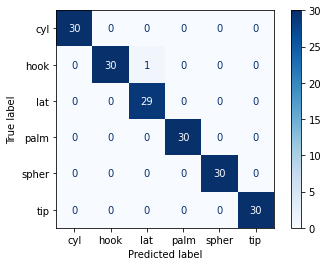

In [ ]:
w_test = []
for i in range(30):      #into subjects
  w_test.append('cyl')
  w_test.append('hook')
  w_test.append('lat')
  w_test.append('palm')
  w_test.append('spher')
  w_test.append('tip')

w_pred = []
y_pred = model.predict(x_test, batch_size=n_batch, verbose=1)
test_ones = np.argmax(y_pred, axis=1)
for x in range(180):
  if test_ones[x] == 0:
    w_pred.append('cyl')
  elif test_ones[x] == 1:
    w_pred.append('hook')
  elif test_ones[x] == 2:
    w_pred.append('lat')
  elif test_ones[x] == 3:
    w_pred.append('palm')
  elif test_ones[x] == 4:
    w_pred.append('spher')
  elif test_ones[x] == 5:
    w_pred.append('tip')

print(test_ones, '\n')

labels = ["cyl", "hook", "lat", "palm", "spher", "tip"]
cm = confusion_matrix(w_pred, w_test, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

print(cm, '\n')

precision_recall_fscore_support(w_pred, w_test, average='weighted')

In [ ]:
done2 = 1
done2

1








****************************************************

### Input 2/1/2 per Subjects

In [ ]:
inputsTF = np.empty((720, 3000, 2))
k=0
m=0
for i in range(120):
  if i == 60:
    m = 30
  for j in range(3000):
    inputsTF[k,j,0]=cyl_ch1[i+m+sbj,j]
    inputsTF[k,j,1]=cyl_ch2[i+m+sbj,j]
    inputsTF[k+1,j,0]=hook_ch1[i+m+sbj,j]
    inputsTF[k+1,j,1]=hook_ch2[i+m+sbj,j]
    inputsTF[k+2,j,0]=lat_ch1[i+m+sbj,j]
    inputsTF[k+2,j,1]=lat_ch2[i+m+sbj,j]
    inputsTF[k+3,j,0]=palm_ch1[i+m+sbj,j]
    inputsTF[k+3,j,1]=palm_ch2[i+m+sbj,j]
    inputsTF[k+4,j,0]=spher_ch1[i+m+sbj,j]
    inputsTF[k+4,j,1]=spher_ch2[i+m+sbj,j]
    inputsTF[k+5,j,0]=tip_ch1[i+m+sbj,j]
    inputsTF[k+5,j,1]=tip_ch2[i+m+sbj,j]
  k=k+6;
inputsTF.shape

(720, 3000, 2)

In [ ]:
inputsPF = np.empty((180, 3000, 2))
k=0
m=60
for i in range(30):
  for j in range(3000):
    inputsPF[k,j,0]=cyl_ch1[i+m+sbj,j]
    inputsPF[k,j,1]=cyl_ch2[i+m+sbj,j]
    inputsPF[k+1,j,0]=hook_ch1[i+m+sbj,j]
    inputsPF[k+1,j,1]=hook_ch2[i+m+sbj,j]
    inputsPF[k+2,j,0]=lat_ch1[i+m+sbj,j]
    inputsPF[k+2,j,1]=lat_ch2[i+m+sbj,j]
    inputsPF[k+3,j,0]=palm_ch1[i+m+sbj,j]
    inputsPF[k+3,j,1]=palm_ch2[i+m+sbj,j]
    inputsPF[k+4,j,0]=spher_ch1[i+m+sbj,j]
    inputsPF[k+4,j,1]=spher_ch2[i+m+sbj,j]
    inputsPF[k+5,j,0]=tip_ch1[i+m+sbj,j]
    inputsPF[k+5,j,1]=tip_ch2[i+m+sbj,j]
  k=k+6;
inputsPF.shape

(180, 3000, 2)

In [ ]:
x_train, x_test = inputsTF, inputsPF
np.array(x_train).shape, np.array(x_test).shape

((720, 3000, 2), (180, 3000, 2))

In [ ]:
all_30_outputs = np.zeros((10, 180))  ##

#### Build Model

In [ ]:
time_steps = np.array(x_train).shape[1]
features = np.array(x_train).shape[2]
n_batch = 180
n_regularizer_k = 0.001
n_regularizer_r = 0.001
n_optimizer = SGD(learning_rate=0.2)
n_dropout = 0.9

n_regularizer_k, n_regularizer_r, n_epochs, n_optimizer, n_depth
model = My_Model(time_steps, features, n_batch, n_regularizer_k, n_regularizer_r, n_dropout, n_depth)  #just first time
model.summary()

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(180, 3000, 2)]     0           []                               
                                                                                                  
 bidirectional_44 (Bidirectiona  (180, 3000, 150)    46800       ['input_23[0][0]']               
 l)                                                                                               
                                                                                                  
 dropout_66 (Dropout)           (180, 3000, 150)     0           ['bidirectional_44[0][0]']       
                                                                                                  
 batch_normalization_66 (BatchN  (180, 3000, 150)    600         ['dropout_66[0][0]']      

In [ ]:
for x in range(10):
  #load model
  del model
  model = My_Model(time_steps, features, n_batch, n_regularizer_k, n_regularizer_r, n_dropout, n_depth)
  # Fit model
  i=0
  while i < (n_epochs):
    print("Model's epoch: ", i)
    model.fit(
        x=x_train,
        y=y_train,
        batch_size=n_batch, 
        epochs=1,
        verbose=1, 
        shuffle=False
        )
    model.reset_states()
    i=i+1
  # Eval Model
  print("Evaluate on test data")
  results = model.evaluate(x_test, y_test, batch_size=n_batch, verbose=1)
  total_acc2 = total_acc2 + results[1]
  print("test loss, test acc:", results)
  #Save values          ###############################################
  y_pred = model.predict(x_test, batch_size=n_batch, verbose=1)
  test_ones = np.argmax(y_pred, axis=1)
  all_30_outputs[x,:] = test_ones
for x in range(10):
  print(all_30_outputs[x,:])

Model's epoch:  0
4/4 [==============================] - 8s 627ms/step - loss: 3.0409 - accuracy: 0.1569
Model's epoch:  1
4/4 [==============================] - 3s 631ms/step - loss: 2.9861 - accuracy: 0.1833
Model's epoch:  2
4/4 [==============================] - 3s 627ms/step - loss: 2.9157 - accuracy: 0.1903
Model's epoch:  3
4/4 [==============================] - 3s 624ms/step - loss: 2.8673 - accuracy: 0.1653
Model's epoch:  4
4/4 [==============================] - 3s 630ms/step - loss: 2.7980 - accuracy: 0.1861
Model's epoch:  5
4/4 [==============================] - 2s 626ms/step - loss: 2.7975 - accuracy: 0.2153
Model's epoch:  6
4/4 [==============================] - 3s 625ms/step - loss: 2.7185 - accuracy: 0.2097
Model's epoch:  7
4/4 [==============================] - 3s 625ms/step - loss: 2.7033 - accuracy: 0.2361
Model's epoch:  8
4/4 [==============================] - 3s 626ms/step - loss: 2.6817 - accuracy: 0.2347
Model's epoch:  9
4/4 [==============================] 

#### Results

In [ ]:
total_acc2 = (total_acc2)/10
print("test acc CV2: ", total_acc2)

test acc CV2:  0.9961111068725585


1/1 [==============================] - 0s 256ms/step
[0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0
 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1
 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2
 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3
 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5] 

[[30  0  0  0  0  0]
 [ 0 30  0  0  0  0]
 [ 0  0 30  0  0  0]
 [ 0  0  0 30  0  0]
 [ 0  0  0  0 30  0]
 [ 0  0  0  0  0 30]] 



(1.0, 1.0, 1.0, None)

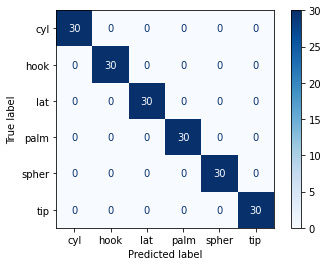

In [ ]:
w_test = []
for i in range(30):      #into subjects
  w_test.append('cyl')
  w_test.append('hook')
  w_test.append('lat')
  w_test.append('palm')
  w_test.append('spher')
  w_test.append('tip')

w_pred = []
y_pred = model.predict(x_test, batch_size=n_batch, verbose=1)
test_ones = np.argmax(y_pred, axis=1)
for x in range(180):
  if test_ones[x] == 0:
    w_pred.append('cyl')
  elif test_ones[x] == 1:
    w_pred.append('hook')
  elif test_ones[x] == 2:
    w_pred.append('lat')
  elif test_ones[x] == 3:
    w_pred.append('palm')
  elif test_ones[x] == 4:
    w_pred.append('spher')
  elif test_ones[x] == 5:
    w_pred.append('tip')

print(test_ones, '\n')

labels = ["cyl", "hook", "lat", "palm", "spher", "tip"]
cm = confusion_matrix(w_pred, w_test, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

print(cm, '\n')

precision_recall_fscore_support(w_pred, w_test, average='weighted')

In [ ]:
done3 = 1
done3

1








****************************************************

### Input 1/1/3 per Subjects

In [ ]:
inputsTF = np.empty((720, 3000, 2))
k=0
m=0
for i in range(120):
  if i == 30:
    m = 30
  for j in range(3000):
    inputsTF[k,j,0]=cyl_ch1[i+m+sbj,j]
    inputsTF[k,j,1]=cyl_ch2[i+m+sbj,j]
    inputsTF[k+1,j,0]=hook_ch1[i+m+sbj,j]
    inputsTF[k+1,j,1]=hook_ch2[i+m+sbj,j]
    inputsTF[k+2,j,0]=lat_ch1[i+m+sbj,j]
    inputsTF[k+2,j,1]=lat_ch2[i+m+sbj,j]
    inputsTF[k+3,j,0]=palm_ch1[i+m+sbj,j]
    inputsTF[k+3,j,1]=palm_ch2[i+m+sbj,j]
    inputsTF[k+4,j,0]=spher_ch1[i+m+sbj,j]
    inputsTF[k+4,j,1]=spher_ch2[i+m+sbj,j]
    inputsTF[k+5,j,0]=tip_ch1[i+m+sbj,j]
    inputsTF[k+5,j,1]=tip_ch2[i+m+sbj,j]
  k=k+6;
inputsTF.shape

(720, 3000, 2)

In [ ]:
inputsPF = np.empty((180, 3000, 2))
k=0
m=30
for i in range(30):
  for j in range(3000):
    inputsPF[k,j,0]=cyl_ch1[i+m+sbj,j]
    inputsPF[k,j,1]=cyl_ch2[i+m+sbj,j]
    inputsPF[k+1,j,0]=hook_ch1[i+m+sbj,j]
    inputsPF[k+1,j,1]=hook_ch2[i+m+sbj,j]
    inputsPF[k+2,j,0]=lat_ch1[i+m+sbj,j]
    inputsPF[k+2,j,1]=lat_ch2[i+m+sbj,j]
    inputsPF[k+3,j,0]=palm_ch1[i+m+sbj,j]
    inputsPF[k+3,j,1]=palm_ch2[i+m+sbj,j]
    inputsPF[k+4,j,0]=spher_ch1[i+m+sbj,j]
    inputsPF[k+4,j,1]=spher_ch2[i+m+sbj,j]
    inputsPF[k+5,j,0]=tip_ch1[i+m+sbj,j]
    inputsPF[k+5,j,1]=tip_ch2[i+m+sbj,j]
  k=k+6;
inputsPF.shape

(180, 3000, 2)

In [ ]:
x_train, x_test = inputsTF, inputsPF
np.array(x_train).shape, np.array(x_test).shape

((720, 3000, 2), (180, 3000, 2))

In [ ]:
all_30_outputs = np.zeros((10, 180))  ##

#### Build Model

In [ ]:
time_steps = np.array(x_train).shape[1]
features = np.array(x_train).shape[2]
n_batch = 180
n_regularizer_k = 0.001
n_regularizer_r = 0.001
n_optimizer = SGD(learning_rate=0.2)
n_dropout = 0.9

n_regularizer_k, n_regularizer_r, n_epochs, n_optimizer, n_depth
model = My_Model(time_steps, features, n_batch, n_regularizer_k, n_regularizer_r, n_dropout, n_depth)  #just first time
model.summary()

Model: "model_33"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_34 (InputLayer)          [(180, 3000, 2)]     0           []                               
                                                                                                  
 bidirectional_66 (Bidirectiona  (180, 3000, 150)    46800       ['input_34[0][0]']               
 l)                                                                                               
                                                                                                  
 dropout_99 (Dropout)           (180, 3000, 150)     0           ['bidirectional_66[0][0]']       
                                                                                                  
 batch_normalization_99 (BatchN  (180, 3000, 150)    600         ['dropout_99[0][0]']      

In [ ]:
for x in range(10):
  #load model
  del model
  model = My_Model(time_steps, features, n_batch, n_regularizer_k, n_regularizer_r, n_dropout, n_depth)
  # Fit model
  i=0
  while i < (n_epochs):
    print("Model's epoch: ", i)
    model.fit(
        x=x_train,
        y=y_train,
        batch_size=n_batch, 
        epochs=1,
        verbose=1, 
        shuffle=False
        )
    model.reset_states()
    i=i+1
  # Eval Model
  print("Evaluate on test data")
  results = model.evaluate(x_test, y_test, batch_size=n_batch, verbose=1)
  total_acc3 = total_acc3 + results[1]
  print("test loss, test acc:", results)
  #Save values          ###############################################
  y_pred = model.predict(x_test, batch_size=n_batch, verbose=1)
  test_ones = np.argmax(y_pred, axis=1)
  all_30_outputs[x,:] = test_ones
for x in range(10):
  print(all_30_outputs[x,:])

Model's epoch:  0
4/4 [==============================] - 8s 634ms/step - loss: 3.0149 - accuracy: 0.1625
Model's epoch:  1
4/4 [==============================] - 3s 637ms/step - loss: 2.9738 - accuracy: 0.1778
Model's epoch:  2
4/4 [==============================] - 3s 640ms/step - loss: 2.9684 - accuracy: 0.1972
Model's epoch:  3
4/4 [==============================] - 3s 635ms/step - loss: 2.8348 - accuracy: 0.2222
Model's epoch:  4
4/4 [==============================] - 3s 643ms/step - loss: 2.8282 - accuracy: 0.2250
Model's epoch:  5
4/4 [==============================] - 3s 637ms/step - loss: 2.7980 - accuracy: 0.2125
Model's epoch:  6
4/4 [==============================] - 3s 640ms/step - loss: 2.8276 - accuracy: 0.2069
Model's epoch:  7
4/4 [==============================] - 3s 641ms/step - loss: 2.7578 - accuracy: 0.2125
Model's epoch:  8
4/4 [==============================] - 3s 641ms/step - loss: 2.7141 - accuracy: 0.2194
Model's epoch:  9
4/4 [==============================] 

#### Results

In [ ]:
total_acc3 = (total_acc3)/10
print("test acc CV3: ", total_acc3)

test acc CV3:  0.9761111080646515


1/1 [==============================] - 0s 256ms/step
[0 1 0 3 4 5 0 1 0 0 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0
 1 2 0 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1
 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2
 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3
 4 5 0 1 2 0 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5] 

[[30  0  2  3  0  0]
 [ 0 30  0  0  0  0]
 [ 0  0 28  0  0  0]
 [ 0  0  0 27  0  0]
 [ 0  0  0  0 30  0]
 [ 0  0  0  0  0 30]] 



(0.9746296296296296, 0.9722222222222222, 0.9717840135263003, None)

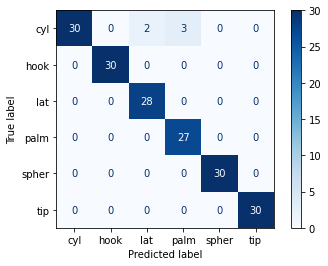

In [ ]:
w_test = []
for i in range(30):      #into subjects
  w_test.append('cyl')
  w_test.append('hook')
  w_test.append('lat')
  w_test.append('palm')
  w_test.append('spher')
  w_test.append('tip')

w_pred = []
y_pred = model.predict(x_test, batch_size=n_batch, verbose=1)
test_ones = np.argmax(y_pred, axis=1)
for x in range(180):
  if test_ones[x] == 0:
    w_pred.append('cyl')
  elif test_ones[x] == 1:
    w_pred.append('hook')
  elif test_ones[x] == 2:
    w_pred.append('lat')
  elif test_ones[x] == 3:
    w_pred.append('palm')
  elif test_ones[x] == 4:
    w_pred.append('spher')
  elif test_ones[x] == 5:
    w_pred.append('tip')

print(test_ones, '\n')

labels = ["cyl", "hook", "lat", "palm", "spher", "tip"]
cm = confusion_matrix(w_pred, w_test, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

print(cm, '\n')

precision_recall_fscore_support(w_pred, w_test, average='weighted')

In [ ]:
done4 = 1
done4

1








****************************************************

### Input 0/1/4 per Subjects

In [ ]:
inputsTF = np.empty((720, 3000, 2))
k=0
m=30
for i in range(120):
  #if i == 0:
  #  m = 30
  for j in range(3000):
    inputsTF[k,j,0]=cyl_ch1[i+m+sbj,j]
    inputsTF[k,j,1]=cyl_ch2[i+m+sbj,j]
    inputsTF[k+1,j,0]=hook_ch1[i+m+sbj,j]
    inputsTF[k+1,j,1]=hook_ch2[i+m+sbj,j]
    inputsTF[k+2,j,0]=lat_ch1[i+m+sbj,j]
    inputsTF[k+2,j,1]=lat_ch2[i+m+sbj,j]
    inputsTF[k+3,j,0]=palm_ch1[i+m+sbj,j]
    inputsTF[k+3,j,1]=palm_ch2[i+m+sbj,j]
    inputsTF[k+4,j,0]=spher_ch1[i+m+sbj,j]
    inputsTF[k+4,j,1]=spher_ch2[i+m+sbj,j]
    inputsTF[k+5,j,0]=tip_ch1[i+m+sbj,j]
    inputsTF[k+5,j,1]=tip_ch2[i+m+sbj,j]
  k=k+6;
inputsTF.shape

(720, 3000, 2)

In [ ]:
inputsPF = np.empty((180, 3000, 2))
k=0
m=0
for i in range(30):
  for j in range(3000):
    inputsPF[k,j,0]=cyl_ch1[i+m+sbj,j]
    inputsPF[k,j,1]=cyl_ch2[i+m+sbj,j]
    inputsPF[k+1,j,0]=hook_ch1[i+m+sbj,j]
    inputsPF[k+1,j,1]=hook_ch2[i+m+sbj,j]
    inputsPF[k+2,j,0]=lat_ch1[i+m+sbj,j]
    inputsPF[k+2,j,1]=lat_ch2[i+m+sbj,j]
    inputsPF[k+3,j,0]=palm_ch1[i+m+sbj,j]
    inputsPF[k+3,j,1]=palm_ch2[i+m+sbj,j]
    inputsPF[k+4,j,0]=spher_ch1[i+m+sbj,j]
    inputsPF[k+4,j,1]=spher_ch2[i+m+sbj,j]
    inputsPF[k+5,j,0]=tip_ch1[i+m+sbj,j]
    inputsPF[k+5,j,1]=tip_ch2[i+m+sbj,j]
  k=k+6;
inputsPF.shape

(180, 3000, 2)

In [ ]:
x_train, x_test = inputsTF, inputsPF
np.array(x_train).shape, np.array(x_test).shape

((720, 3000, 2), (180, 3000, 2))

In [ ]:
all_30_outputs = np.zeros((10, 180))  ##

#### Build Model

In [ ]:
time_steps = np.array(x_train).shape[1]
features = np.array(x_train).shape[2]
n_batch = 180
n_regularizer_k = 0.001
n_regularizer_r = 0.001
n_optimizer = SGD(learning_rate=0.2)
n_dropout = 0.9

n_regularizer_k, n_regularizer_r, n_epochs, n_optimizer, n_depth
model = My_Model(time_steps, features, n_batch, n_regularizer_k, n_regularizer_r, n_dropout, n_depth)  #just first time
model.summary()

Model: "model_44"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_45 (InputLayer)          [(180, 3000, 2)]     0           []                               
                                                                                                  
 bidirectional_88 (Bidirectiona  (180, 3000, 150)    46800       ['input_45[0][0]']               
 l)                                                                                               
                                                                                                  
 dropout_132 (Dropout)          (180, 3000, 150)     0           ['bidirectional_88[0][0]']       
                                                                                                  
 batch_normalization_132 (Batch  (180, 3000, 150)    600         ['dropout_132[0][0]']     

In [ ]:
for x in range(10):
  #load model
  del model
  model = My_Model(time_steps, features, n_batch, n_regularizer_k, n_regularizer_r, n_dropout, n_depth)
  # Fit model
  i=0
  while i < (n_epochs):
    print("Model's epoch: ", i)
    model.fit(
        x=x_train,
        y=y_train,
        batch_size=n_batch, 
        epochs=1,
        verbose=1, 
        shuffle=False
        )
    model.reset_states()
    i=i+1
  # Eval Model
  print("Evaluate on test data")
  results = model.evaluate(x_test, y_test, batch_size=n_batch, verbose=1)
  total_acc4 = total_acc4 + results[1]
  print("test loss, test acc:", results)
  #Save values          ###############################################
  y_pred = model.predict(x_test, batch_size=n_batch, verbose=1)
  test_ones = np.argmax(y_pred, axis=1)
  all_30_outputs[x,:] = test_ones
for x in range(10):
  print(all_30_outputs[x,:])

Model's epoch:  0
4/4 [==============================] - 8s 631ms/step - loss: 2.9916 - accuracy: 0.1667
Model's epoch:  1
4/4 [==============================] - 3s 632ms/step - loss: 2.9483 - accuracy: 0.1639
Model's epoch:  2
4/4 [==============================] - 3s 631ms/step - loss: 2.8840 - accuracy: 0.2194
Model's epoch:  3
4/4 [==============================] - 3s 633ms/step - loss: 2.8308 - accuracy: 0.1861
Model's epoch:  4
4/4 [==============================] - 3s 631ms/step - loss: 2.8019 - accuracy: 0.2278
Model's epoch:  5
4/4 [==============================] - 3s 632ms/step - loss: 2.7047 - accuracy: 0.2181
Model's epoch:  6
4/4 [==============================] - 3s 636ms/step - loss: 2.6635 - accuracy: 0.2569
Model's epoch:  7
4/4 [==============================] - 3s 635ms/step - loss: 2.6930 - accuracy: 0.2514
Model's epoch:  8
4/4 [==============================] - 3s 638ms/step - loss: 2.6086 - accuracy: 0.2500
Model's epoch:  9
4/4 [==============================] 

#### Results

In [ ]:
total_acc4 = (total_acc4)/10
print("test acc CV4: ", total_acc4)

test acc CV4:  0.9338888823986053


1/1 [==============================] - 0s 263ms/step
[5 5 5 5 4 5 0 5 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 5 2 3 4 5 0
 1 2 5 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 5 4 5 0 1
 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2
 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 5 2 3 5 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3
 4 5 0 5 2 3 4 5 0 5 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5] 

[[29  0  0  0  0  0]
 [ 0 24  0  0  0  0]
 [ 0  0 29  0  0  0]
 [ 0  0  0 27  0  0]
 [ 0  0  0  0 29  0]
 [ 1  6  1  3  1 30]] 



(0.9422222222222222, 0.9333333333333333, 0.9302094690587108, None)

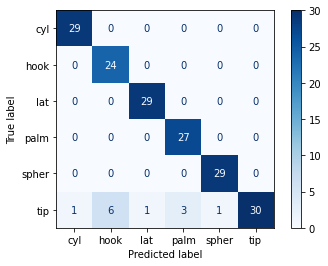

In [ ]:
w_test = []
for i in range(30):      #into subjects
  w_test.append('cyl')
  w_test.append('hook')
  w_test.append('lat')
  w_test.append('palm')
  w_test.append('spher')
  w_test.append('tip')

w_pred = []
y_pred = model.predict(x_test, batch_size=n_batch, verbose=1)
test_ones = np.argmax(y_pred, axis=1)
for x in range(180):
  if test_ones[x] == 0:
    w_pred.append('cyl')
  elif test_ones[x] == 1:
    w_pred.append('hook')
  elif test_ones[x] == 2:
    w_pred.append('lat')
  elif test_ones[x] == 3:
    w_pred.append('palm')
  elif test_ones[x] == 4:
    w_pred.append('spher')
  elif test_ones[x] == 5:
    w_pred.append('tip')

print(test_ones, '\n')

labels = ["cyl", "hook", "lat", "palm", "spher", "tip"]
cm = confusion_matrix(w_pred, w_test, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

print(cm, '\n')

precision_recall_fscore_support(w_pred, w_test, average='weighted')

In [ ]:
done5 = 1
done5

1








****************************************************

### Result Total

In [ ]:
#total_acc0 = 0.9949999928474427
#total_acc1 = 0.9938888847827911
#total_acc2 = 0.997777771949768
#total_acc3 = 0.9755555510520935
#total_acc4 = 0.9205555617809296

In [ ]:
total_accS1 = (total_acc0+total_acc1+total_acc2+total_acc3+total_acc4)/5
print('Average Accuracy First Subject', total_accS1)

Average Accuracy First Subject 0.9794444394111632


[[29  0  0  0  0  0]
 [ 0 24  0  0  0  0]
 [ 0  0 29  0  0  0]
 [ 0  0  0 27  0  0]
 [ 0  0  0  0 29  0]
 [ 1  6  1  3  1 30]] 



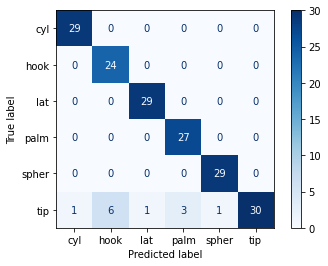

In [ ]:
disp.plot(cmap=plt.cm.Blues)

print(cm, '\n')

------------------------------------------------

## ...

In [ ]:
order = 66
order

66

In [ ]:
total_acc = (total_accS1+total_accS2+total_accS3+total_accS4+total_accS5)/5
print('The Final Accuracy is:  ', total_acc)

In [ ]:
labels = ["cyl", "hook", "lat", "palm", "spher", "tip"]
cm = confusion_matrix(w_pred, w_test, labels=labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm, vmin=0, vmax=150, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
labels = ["cyl", "hook", "lat", "palm", "spher", "tip"]
cm = confusion_matrix(w_pred, w_test, labels=labels, normalize='all')
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm, vmin=0, vmax=1, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
total_acc
